Using device: cuda
Target Sampling Rate (Hz): 1000.0
Window Size (samples): 2000
Classes: ['man', 'car', 'other']
Base Data Directory: DATA
Using Aggressive Augmentation for 'other' class.

Looking for new 'other' files in DATA\OTHER...
  Found 7 potential new 'other' files.

--- Processing 'man' Data Files ---
  Processing file: man.csv (Label: man)...
    Created 1221 windows for this file.

--- Processing 'man2' Data Files (354 files) ---
  Processing file: P1_Barefoot_01.csv (Label: man)...
    Created 36 windows for this file.
  Processing file: P1_Barefoot_02.csv (Label: man)...
    Created 36 windows for this file.
  Processing file: P1_Barefoot_03.csv (Label: man)...
    Created 36 windows for this file.
  Processing file: P1_Barefoot_04.csv (Label: man)...
    Created 36 windows for this file.
  Processing file: P1_Barefoot_05.csv (Label: man)...
    Created 36 windows for this file.
  Processing file: P1_Shoe1_01.csv (Label: man)...
    Created 36 windows for this file.
  Pro

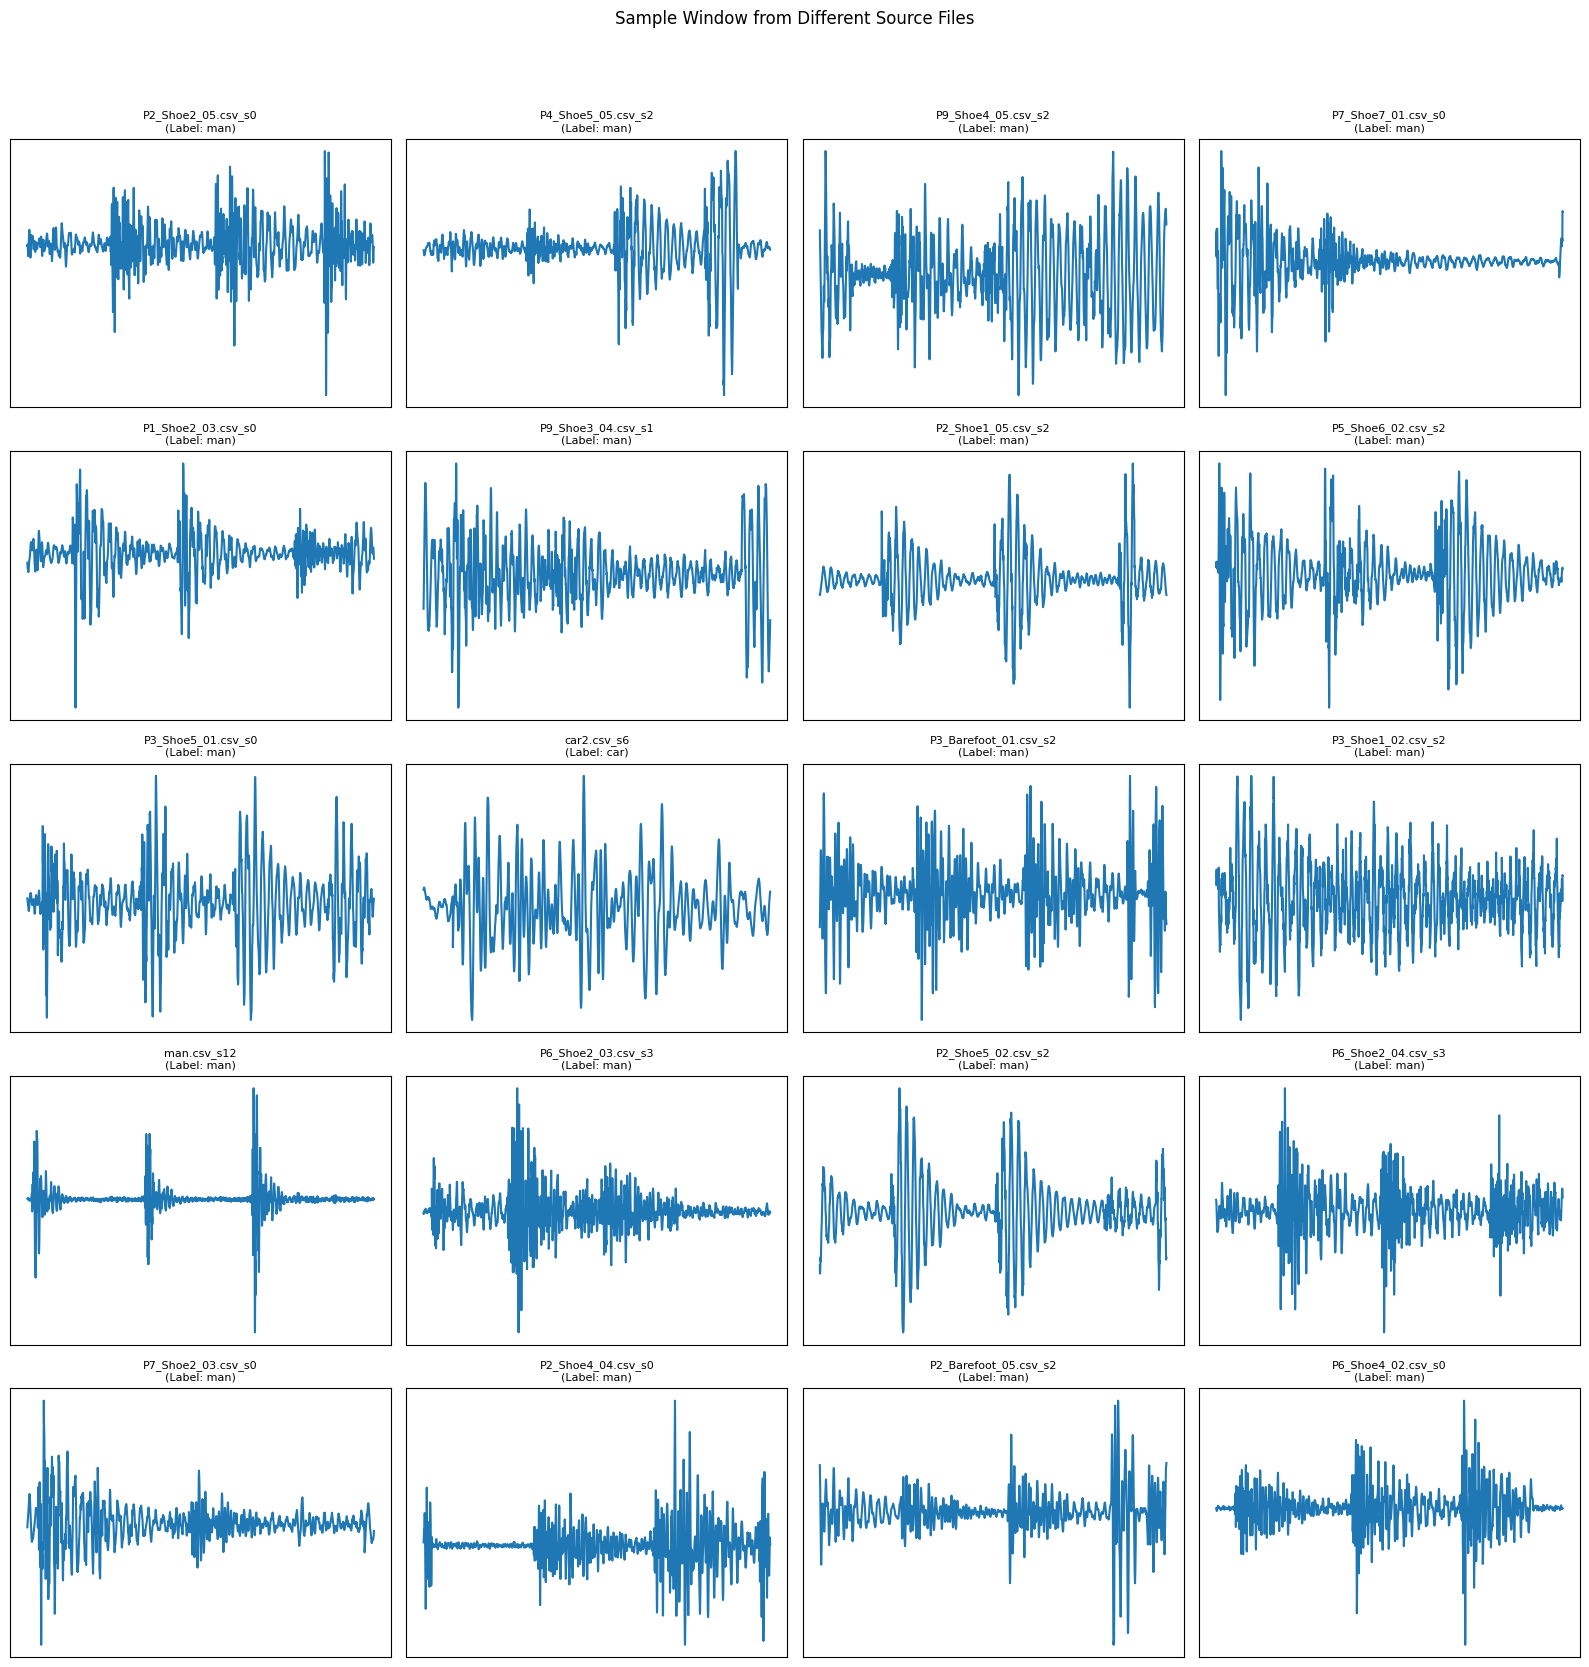


Plotting raw signal examples per CLASS...


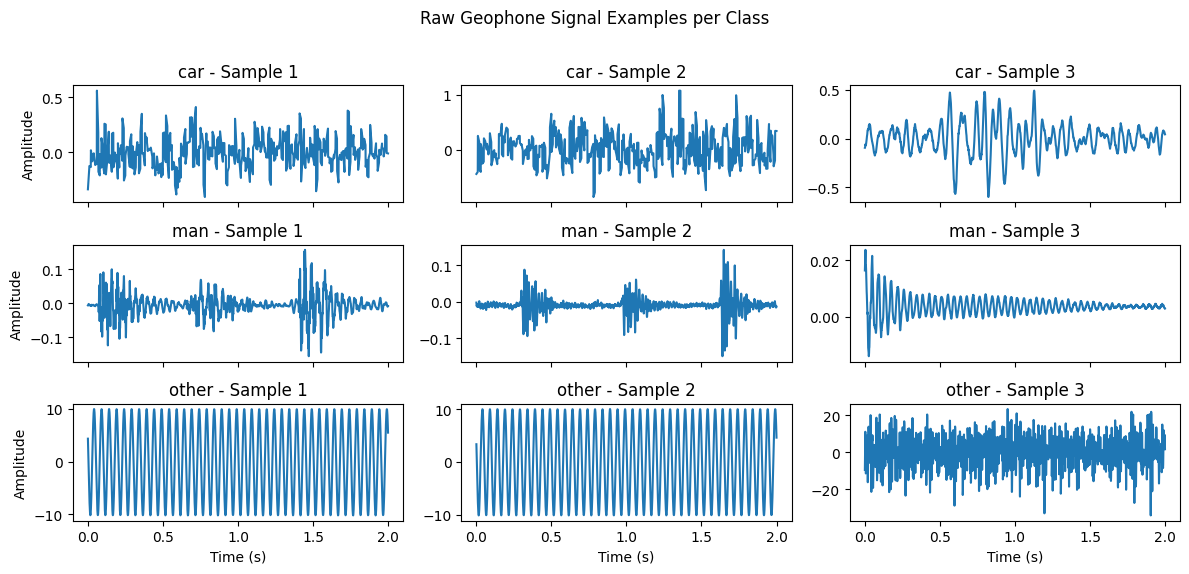


Plotting FFT examples per CLASS...


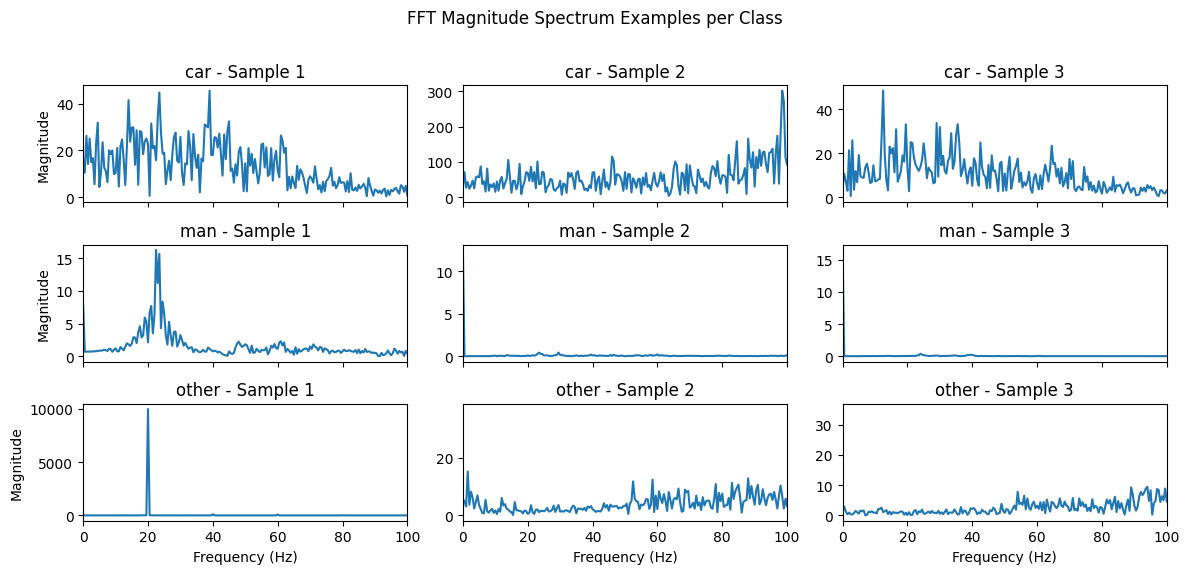


Model Architecture (3 Classes):
Total Trainable Parameters: 2,057,667

--- Starting Training (3 Classes with Aggressive Aug for 'other') ---


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60] - Train Loss: 0.6811, Acc: 0.8145 | Val Loss: 0.4778, Acc: 0.9225 | LR: 0.000100
Epoch [2/60] - Train Loss: 0.4709, Acc: 0.8918 | Val Loss: 0.3622, Acc: 0.9194 | LR: 0.000100
Epoch [3/60] - Train Loss: 0.4019, Acc: 0.8965 | Val Loss: 0.3455, Acc: 0.9377 | LR: 0.000100
Epoch [4/60] - Train Loss: 0.3914, Acc: 0.8990 | Val Loss: 0.3150, Acc: 0.9176 | LR: 0.000100
Epoch [5/60] - Train Loss: 0.3917, Acc: 0.8933 | Val Loss: 0.3062, Acc: 0.9242 | LR: 0.000100
Epoch [6/60] - Train Loss: 0.3708, Acc: 0.8917 | Val Loss: 0.2981, Acc: 0.9263 | LR: 0.000100
Epoch [7/60] - Train Loss: 0.3550, Acc: 0.8933 | Val Loss: 0.2914, Acc: 0.9260 | LR: 0.000100
Epoch [8/60] - Train Loss: 0.3565, Acc: 0.8904 | Val Loss: 0.2914, Acc: 0.9287 | LR: 0.000100
Epoch [9/60] - Train Loss: 0.3464, Acc: 0.9015 | Val Loss: 0.2911, Acc: 0.9343 | LR: 0.000100
Epoch [10/60] - Train Loss: 0.3417, Acc: 0.8980 | Val Loss: 0.2838, Acc: 0.9346 | LR: 0.000100
Epoch [11/60] - Train Loss: 0.3322, Acc: 0.9007 | Val Loss:

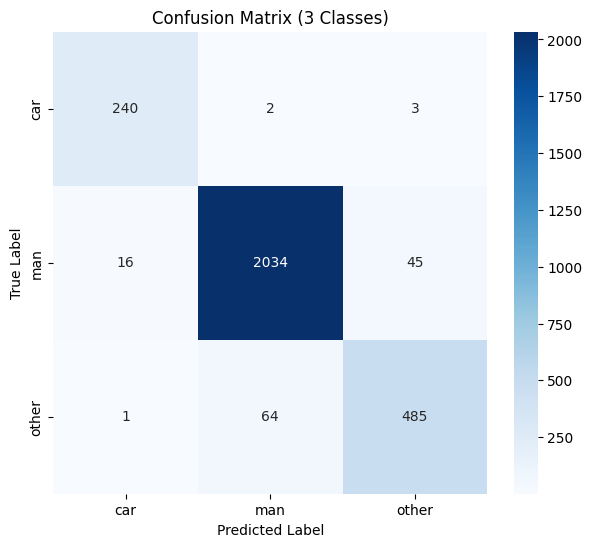


Plotting training history...


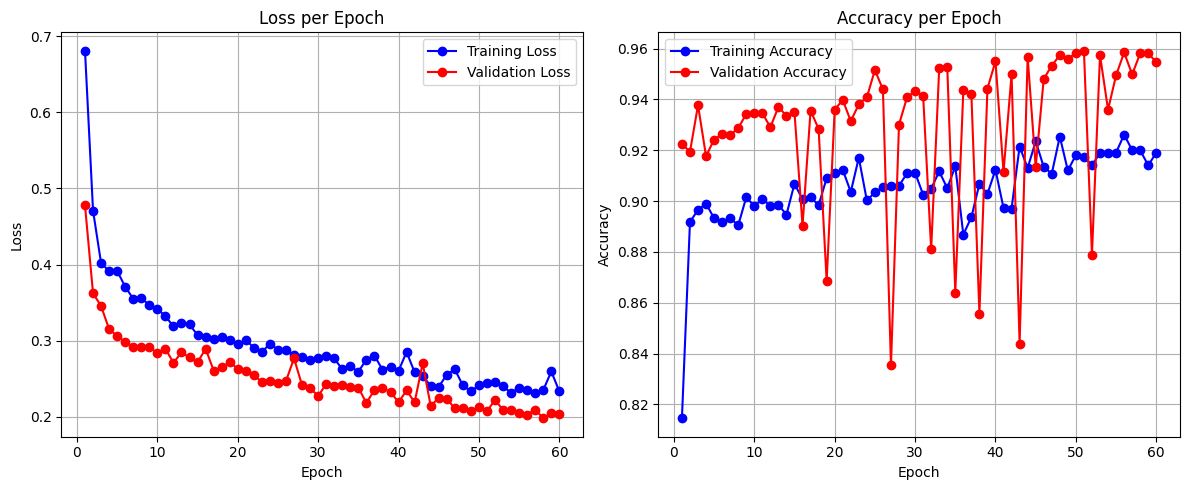


--- Script Finished ---


In [4]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import os
import glob
from collections import Counter, defaultdict
import time
import math
import random
import traceback

# --- Configuration ---
BASE_DATA_DIR = 'DATA' # Base directory containing all CSVs (including new 'other' files)
MAN2_FOLDER_NAME = 'man2' # Subdirectory for additional 'man' files
# --- !!! NEW: Directory for the new 'other' files !!! ---
# Assuming you moved all new CSVs (aircraft, commute etc.) into a folder named 'OTHER' inside 'DATA'
OTHER_FOLDER_NAME = 'OTHER'
# ----------------------------------------------------------

# Using Original Sampling Rate
TARGET_SAMPLING_RATE = 1000.0

# Parameters based on TARGET_SAMPLING_RATE
WINDOW_SECONDS = 2.0
STEP_SECONDS = 1.0
WINDOW_SIZE = int(TARGET_SAMPLING_RATE * WINDOW_SECONDS) # 1000
STEP_SIZE = int(TARGET_SAMPLING_RATE * STEP_SECONDS)     # 500

# Model & Training Params
BATCH_SIZE = 128
LEARNING_RATE = 0.0001 # Reduced LR
GRADIENT_CLIP_VALUE = 1.0 # Grad Clip
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.5
NUM_EPOCHS = 60 # Allow more epochs
VALIDATION_SPLIT_RATIO = 0.15
TEST_SPLIT_RATIO = 0.15
EARLY_STOPPING_PATIENCE = 10
LR_SCHEDULER_PATIENCE = 5
LR_SCHEDULER_FACTOR = 0.1

# Augmentation Params
AUGMENT_GAUSSIAN_STD = 0.01
AUGMENT_AMPLITUDE_RANGE = (0.9, 1.1)
AUGMENT_TIME_SHIFT_MAX_FRACTION = 0.1
AUGMENT_OTHER_GAUSSIAN_STD = 0.05
AUGMENT_OTHER_AMPLITUDE_RANGE = (0.7, 1.3)
AUGMENT_OTHER_TIME_SHIFT_MAX_FRACTION = 0.2

# Other Settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
# Define ALL classes
ALL_CLASSES = ['man', 'car', 'other']
OTHER_LABEL_STR = 'other'

# --- Setup Reproducibility ---
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
print(f"Using device: {DEVICE}")
print(f"Target Sampling Rate (Hz): {TARGET_SAMPLING_RATE}")
print(f"Window Size (samples): {WINDOW_SIZE}")
print(f"Classes: {ALL_CLASSES}")
print(f"Base Data Directory: {BASE_DATA_DIR}")
print(f"Using Aggressive Augmentation for '{OTHER_LABEL_STR}' class.")

# --- Data Loading ---
def load_data_from_file(filepath):
    """Loads data from a single CSV file."""
    try:
        df = pd.read_csv(filepath, header=None)
        if df.shape[1] == 0: print(f"    Warning: File {filepath} has no columns."); return None
        df.fillna(0.0, inplace=True) # Replace NaNs with 0
        return df.values.astype(np.float32)
    except pd.errors.EmptyDataError: print(f"    Warning: File {filepath} is empty."); return None
    except Exception as e: print(f"    Error loading {filepath}: {e}"); return None

# --- Function to Load and Create Windows (No Resampling) ---
def process_file_no_resample(filepath, label, window_size, step_size, label_encoder):
    """Loads data and creates windows without resampling."""
    print(f"  Processing file: {os.path.basename(filepath)} (Label: {label})...")
    file_windows, file_labels, file_sources = [], [], [] # Use local lists for this file
    try:
        original_data = load_data_from_file(filepath)
        if original_data is None or original_data.shape[0] < window_size: return [], [], []

        num_sensors, num_samples = original_data.shape[1], original_data.shape[0]
        label_idx = label_encoder.transform([label])[0]
        base_filename = os.path.basename(filepath)

        for sensor_idx in range(num_sensors):
            sensor_data = original_data[:, sensor_idx]
            if np.isnan(sensor_data).any() or np.isinf(sensor_data).any():
                print(f"    Warning: NaN/Inf found in sensor {sensor_idx} of {base_filename}. Cleaning.")
                sensor_data = np.nan_to_num(sensor_data, nan=0.0, posinf=0.0, neginf=0.0)

            for start in range(0, num_samples - window_size + 1, step_size):
                window = sensor_data[start:start + window_size]
                if not np.isnan(window).any() and not np.isinf(window).any():
                    file_windows.append(window.reshape(1, -1)) # Add channel dim
                    file_labels.append(label_idx)
                    file_sources.append(f"{base_filename}_s{sensor_idx}")

        print(f"    Created {len(file_windows)} windows for this file.")
        return file_windows, file_labels, file_sources

    except Exception as e:
        print(f"    Error processing file {filepath}: {e}")
        traceback.print_exc()
        return [], [], []

# --- Load All Files, Create Windows, Assign Labels ---
all_windows_list = []
all_labels_list = []
all_sources_list = []
label_encoder_3class = LabelEncoder().fit(ALL_CLASSES)
other_class_index = label_encoder_3class.transform([OTHER_LABEL_STR])[0]

# Define file lists for each category
man_files = ['man.csv']
car_files = ['car.csv', 'car2.csv', 'car3.csv', 'car4.csv']
# Original 'other' files
original_other_files = ['nothing.csv', 'noise.csv']
# New 'other' files assumed to be in DATA/OTHER folder
new_other_dir = os.path.join(BASE_DATA_DIR, OTHER_FOLDER_NAME)
new_other_files = []
if os.path.isdir(new_other_dir):
    print(f"\nLooking for new 'other' files in {new_other_dir}...")
    new_other_files = glob.glob(os.path.join(new_other_dir, '*.csv'))
    print(f"  Found {len(new_other_files)} potential new 'other' files.")
else:
    print(f"Warning: Directory for new 'other' files not found: {new_other_dir}")

# Process 'man' files
print("\n--- Processing 'man' Data Files ---")
for fname in man_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_no_resample(filepath, 'man', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)
# Process 'man2' files
man2_dir_path = os.path.join(BASE_DATA_DIR, MAN2_FOLDER_NAME)
if os.path.isdir(man2_dir_path):
    man2_csvs = glob.glob(os.path.join(man2_dir_path, '*.csv'))
    print(f"\n--- Processing 'man2' Data Files ({len(man2_csvs)} files) ---")
    for filepath in man2_csvs:
        windows, labels, sources = process_file_no_resample(filepath, 'man', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)

# Process 'car' files
print("\n--- Processing 'car' Data Files ---")
for fname in car_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_no_resample(filepath, 'car', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)

# Process 'other' files (Original + New)
print("\n--- Processing 'other' Data Files ---")
# Process original other files
for fname in original_other_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_no_resample(filepath, 'other', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)
    else: print(f"  Warning: Original 'other' file not found - {filepath}")
# Process new other files
if new_other_files:
    print("\n--- Processing NEW 'other' Data Files ---")
    for filepath in new_other_files:
         # Assuming all files in OTHER folder should be labeled 'other'
        windows, labels, sources = process_file_no_resample(filepath, 'other', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)


# Convert lists to numpy arrays
if all_windows_list:
     all_windows_np = np.stack(all_windows_list, axis=0).astype(np.float32)
else: all_windows_np = np.empty((0, 1, WINDOW_SIZE), dtype=np.float32)
all_labels_np = np.array(all_labels_list, dtype=np.int64) if all_labels_list else np.empty(0, dtype=np.int64)
print(f"\nTotal windows from all sources: {len(all_windows_np)}")
if len(all_windows_np) > 0:
    print(f"Shape of final window data: {all_windows_np.shape}")
    print(f"Shape of final label data: {all_labels_np.shape}")
else: print("Warning: No windows created from any files.")


# --- Analyze Window Distribution (Corrected Function) ---
def print_window_summary(split_name, y_labels, encoder):
    """Prints the distribution of labels (windows) in a dataset split."""
    if isinstance(y_labels, (np.ndarray, list)) and len(y_labels) == 0: counts = {}; total = 0
    elif isinstance(y_labels, np.ndarray): counts = Counter(y_labels); total = len(y_labels)
    elif isinstance(y_labels, list): counts = Counter(y_labels); total = len(y_labels)
    else: print(f"Warning: Unexpected type for labels in {split_name}: {type(y_labels)}."); return
    if total == 0: print(f"  {split_name}: No windows generated."); return
    summary = []; [summary.append(f'{class_name}: {counts.get(i, 0)}') for i, class_name in enumerate(encoder.classes_)]
    print(f"  {split_name} (Total: {total}):   [{', '.join(summary)}]")

print("\nLabel distribution in combined data:")
if len(all_labels_np) > 0: print_window_summary("Combined", all_labels_np, label_encoder_3class)
else: print("  Combined: No windows generated.")


# --- Split Combined Data into Train/Val/Test ---
if len(all_windows_np) > 0:
    try:
        indices = np.arange(len(all_windows_np))
        min_samples_per_class = Counter(all_labels_np).most_common()[-1][1] if Counter(all_labels_np) else 0
        n_splits_required = 2
        if min_samples_per_class < n_splits_required: raise ValueError(f"Min samples per class ({min_samples_per_class}) < {n_splits_required}")
        train_val_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT_RATIO, stratify=all_labels_np, random_state=SEED)
        min_samples_train_val = Counter(all_labels_np[train_val_idx]).most_common()[-1][1] if Counter(all_labels_np[train_val_idx]) else 0
        if min_samples_train_val < n_splits_required: raise ValueError(f"Min samples per class in train/val ({min_samples_train_val}) < {n_splits_required}")
        val_split_ratio_adj = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO)
        train_idx, val_idx = train_test_split(train_val_idx, test_size=val_split_ratio_adj, stratify=all_labels_np[train_val_idx], random_state=SEED)
        X_train = all_windows_np[train_idx]; y_train = all_labels_np[train_idx]; sources_train = [all_sources_list[i] for i in train_idx]
        X_val = all_windows_np[val_idx]; y_val = all_labels_np[val_idx]; sources_val = [all_sources_list[i] for i in val_idx]
        X_test = all_windows_np[test_idx]; y_test = all_labels_np[test_idx]; sources_test = [all_sources_list[i] for i in test_idx]
    except ValueError as e: # Catch explicit error or fallback from stratification check
        print(f"\nWarning: Stratified split failed ({e}). Falling back to non-stratified split.")
        indices = np.arange(len(all_windows_np)); train_val_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT_RATIO, random_state=SEED)
        val_split_ratio_adj = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO); train_idx, val_idx = train_test_split(train_val_idx, test_size=val_split_ratio_adj, random_state=SEED)
        X_train = all_windows_np[train_idx]; y_train = all_labels_np[train_idx]; sources_train = [all_sources_list[i] for i in train_idx]
        X_val = all_windows_np[val_idx]; y_val = all_labels_np[val_idx]; sources_val = [all_sources_list[i] for i in val_idx]
        X_test = all_windows_np[test_idx]; y_test = all_labels_np[test_idx]; sources_test = [all_sources_list[i] for i in test_idx]
else: raise ValueError("No windows available for splitting.")


# --- Analyze Window Distribution per Set ---
print("\nWindow Distribution per Split Set:")
print_window_summary("Training", y_train, label_encoder_3class)
print_window_summary("Validation", y_val, label_encoder_3class)
print_window_summary("Test", y_test, label_encoder_3class)

# Critical Check for Empty Sets
if len(X_train) == 0: raise ValueError("CRITICAL ERROR: Training set empty after split!")
if len(X_val) == 0: print("\nWARNING: Validation set empty after split!")
if len(X_test) == 0: print("\nWARNING: Test set empty after split!")


# --- Calculate Class Weights (for 3 classes) ---
if len(y_train) > 0:
    class_counts = np.bincount(y_train, minlength=len(ALL_CLASSES))
    total_samples = len(y_train)
    class_weights = total_samples / (len(class_counts) * class_counts + 1e-6)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    print(f"\nCalculated Class Weights (3 Classes): {class_weights_tensor.cpu().numpy()}")
    for i, cls_name in enumerate(label_encoder_3class.classes_):
        count_str = str(class_counts[i]) if i < len(class_counts) else "N/A"; weight_str = f"{class_weights[i]:.4f}" if i < len(class_weights) else "N/A"
        print(f"  Weight for '{cls_name}': {weight_str} (Count: {count_str})")
else: print("\nWarning: Training set empty."); class_weights_tensor = torch.ones(len(ALL_CLASSES), dtype=torch.float).to(DEVICE)

# --- PyTorch Dataset with Conditional Augmentation ---
class GeophoneAugmentedDataset(Dataset):
    # (Definition remains the same)
    def __init__(self, features, labels, source_files, window_size, augment=False, other_idx=None):
        self.is_empty = features.size == 0 if isinstance(features, np.ndarray) else (len(features) == 0)
        if self.is_empty: self.features_np = np.empty((0, window_size)); self.labels_np = np.empty(0, dtype=np.int64); self.source_files = []
        else:
            self.features_np = features; self.labels_np = labels; self.source_files = source_files
            if self.features_np.ndim == 3 and self.features_np.shape[1] == 1: self.features_np = np.squeeze(self.features_np, axis=1)
            elif self.features_np.ndim != 2: raise ValueError(f"Unsupported feature dimensions: {self.features_np.shape}")
        self.window_size = window_size; self.augment = augment; self.other_idx = other_idx
    def __len__(self): return len(self.labels_np) if not self.is_empty else 0
    def __getitem__(self, idx):
        if self.is_empty: raise IndexError("Dataset is empty")
        if self.features_np.ndim != 2: raise ValueError(f"Features array incorrect dims: {self.features_np.shape}")
        signal = self.features_np[idx].copy(); label = self.labels_np[idx]; source = self.source_files[idx] if idx < len(self.source_files) else "N/A" # Safety check for source_files length
        if self.augment:
            is_other = (self.other_idx is not None and label == self.other_idx)
            amp_range = AUGMENT_OTHER_AMPLITUDE_RANGE if is_other else AUGMENT_AMPLITUDE_RANGE
            gauss_std = AUGMENT_OTHER_GAUSSIAN_STD if is_other else AUGMENT_GAUSSIAN_STD
            shift_frac = AUGMENT_OTHER_TIME_SHIFT_MAX_FRACTION if is_other else AUGMENT_TIME_SHIFT_MAX_FRACTION
            max_shift = int(self.window_size * shift_frac)
            if max_shift > 0 : shift = random.randint(-max_shift, max_shift); signal = np.roll(signal, shift) if shift != 0 else signal
            scale_factor = random.uniform(amp_range[0], amp_range[1]); signal = signal * scale_factor
            if gauss_std > 0:
                 signal_std_val = np.std(signal)
                 if signal_std_val > 1e-9: noise_std = gauss_std * signal_std_val; noise = np.random.normal(0, noise_std, signal.shape); signal = signal + noise
        signal_tensor = torch.from_numpy(signal).float().unsqueeze(0); label_tensor = torch.tensor(label, dtype=torch.long)
        return signal_tensor, label_tensor, source

# Create Datasets
train_dataset = GeophoneAugmentedDataset(X_train, y_train, sources_train, WINDOW_SIZE, augment=True, other_idx=other_class_index)
val_dataset = GeophoneAugmentedDataset(X_val, y_val, sources_val, WINDOW_SIZE, augment=False)
test_dataset = GeophoneAugmentedDataset(X_test, y_test, sources_test, WINDOW_SIZE, augment=False)

# --- PyTorch DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nUsing standard shuffling for Training DataLoader.")
print(f"DataLoaders created. Batches per epoch (Train): {len(train_loader)}")


# --- Visualization Functions (Full Definitions) ---
def plot_samples_per_file(dataset, label_encoder, n_samples_per_file=1, max_files_to_plot=20):
    """Plots example windows, one from each unique source file."""
    print(f"\nPlotting samples per source file (max {max_files_to_plot} files)...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    indices_by_source = defaultdict(list)
    if not hasattr(dataset, 'source_files') or not dataset.source_files: print("  No source file info."); return
    for i, source_file in enumerate(dataset.source_files): indices_by_source[source_file].append(i)
    unique_files = list(indices_by_source.keys()); random.shuffle(unique_files) # Shuffle for variety
    if len(unique_files) > max_files_to_plot: plot_files = unique_files[:max_files_to_plot]
    else: plot_files = unique_files
    n_files = len(plot_files);
    if n_files == 0: print("  No files found."); return
    cols = min(4, n_files); rows = math.ceil(n_files / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5), squeeze=False); fig.suptitle('Sample Window from Different Source Files')
    axs = axs.flatten()
    time_axis = np.linspace(0, WINDOW_SECONDS, dataset.window_size)
    plot_idx = 0
    for i, filename in enumerate(plot_files):
        if plot_idx >= len(axs): break
        file_indices = indices_by_source[filename]; sample_indices = random.sample(file_indices, min(n_samples_per_file, len(file_indices)))
        if sample_indices:
            idx = sample_indices[0];
            try: # Add try-except for __getitem__ call
                 signal, label_idx, _ = dataset[idx];
                 signal = signal.squeeze().cpu().numpy(); label_name = label_encoder.classes_[label_idx.item()]
                 axs[plot_idx].plot(time_axis, signal); axs[plot_idx].set_title(f"{filename}\n(Label: {label_name})", fontsize=8); axs[plot_idx].set_xticks([]); axs[plot_idx].set_yticks([]); plot_idx += 1
            except Exception as e:
                 print(f"Error getting/plotting sample {idx} from {filename}: {e}")
    for j in range(plot_idx, len(axs)): axs[j].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def plot_raw_signals(dataset, label_encoder, n_samples=3):
    """Plots raw signal examples for each class (uses original numpy data)."""
    print("\nPlotting raw signal examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_); fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 2), sharex=True, squeeze=False); fig.suptitle('Raw Geophone Signal Examples per Class')
    time_axis = np.linspace(0, WINDOW_SECONDS, dataset.window_size); all_labels_np = dataset.labels_np
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                 if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples', ha='center', va='center'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
             if i < axs.shape[0] and j < axs.shape[1]:
                signal_np = dataset.features_np[sample_idx] # Use original numpy signal
                axs[i, j].plot(time_axis, signal_np); axs[i, j].set_title(f"{class_name} - Sample {j+1}")
                if i == num_classes - 1: axs[i, j].set_xlabel('Time (s)')
                if j == 0: axs[i, j].set_ylabel('Amplitude')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

def plot_fft_signals(dataset, label_encoder, n_samples=3):
    """Plots FFT magnitude spectrum examples for each class (uses original numpy data)."""
    print("\nPlotting FFT examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_); fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 2), sharex=True, squeeze=False); fig.suptitle('FFT Magnitude Spectrum Examples per Class')
    freq_axis = np.fft.rfftfreq(dataset.window_size, 1.0/TARGET_SAMPLING_RATE); all_labels_np = dataset.labels_np
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples', ha='center', va='center'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
            if i < axs.shape[0] and j < axs.shape[1]:
                signal_np = dataset.features_np[sample_idx] # Use original numpy signal
                fft_vals = np.fft.rfft(signal_np); fft_mag = np.abs(fft_vals); axs[i, j].plot(freq_axis, fft_mag)
                axs[i, j].set_title(f"{class_name} - Sample {j+1}");
                if i == num_classes - 1: axs[i, j].set_xlabel('Frequency (Hz)')
                if j == 0: axs[i, j].set_ylabel('Magnitude')
                axs[i,j].set_xlim(0, TARGET_SAMPLING_RATE / 10) # Show up to 100Hz
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

# --- Plot initial visualizations ---
if len(train_dataset) > 0:
    plot_samples_per_file(train_dataset, label_encoder_3class)
    plot_raw_signals(train_dataset, label_encoder_3class)
    plot_fft_signals(train_dataset, label_encoder_3class)
else: print("\nTraining dataset empty, skipping initial visualizations.")

# --- Model Definition (3 classes) ---
class Simple1DCNN_3Class(nn.Module):
    # (Definition remains the same)
    def __init__(self, num_classes, window_size, dropout_rate):
        super(Simple1DCNN_3Class, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv1d(1, 16, 7, 1, 3), nn.BatchNorm1d(16), nn.ReLU(), nn.MaxPool1d(2, 2))
        self.conv_block2 = nn.Sequential(nn.Conv1d(16, 32, 5, 1, 2), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2, 2))
        self.conv_block3 = nn.Sequential(nn.Conv1d(32, 64, 3, 1, 1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2, 2))
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, window_size); dummy_output = self.conv_block3(self.conv_block2(self.conv_block1(dummy_input)))
            self.flattened_size = dummy_output.numel();
            if self.flattened_size <= 0 : raise ValueError(f"Flattened size invalid: {self.flattened_size}.")
        self.fc_block = nn.Sequential(nn.Flatten(), nn.Linear(self.flattened_size, 128), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.conv_block1(x); x = self.conv_block2(x); x = self.conv_block3(x); x = self.fc_block(x); return x

# Instantiate the model
model = Simple1DCNN_3Class(num_classes=len(ALL_CLASSES), window_size=WINDOW_SIZE, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("\nModel Architecture (3 Classes):")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

# --- Training Setup ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)

# --- Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf'); epochs_no_improve = 0; best_model_state = None
run_validation = len(val_dataset) > 0
if not run_validation: best_val_loss = -1

print("\n--- Starting Training (3 Classes with Aggressive Aug for 'other') ---")
start_time = time.time()
# (Training loop remains the same)
for epoch in range(NUM_EPOCHS):
    model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
    for i, batch_data in enumerate(train_loader):
        if len(batch_data) == 3: inputs, labels, _ = batch_data
        elif len(batch_data) == 2: inputs, labels = batch_data
        else: raise ValueError(f"Unexpected batch structure: {batch_data}")
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0
    history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)
    epoch_val_loss, epoch_val_acc = float('nan'), float('nan')
    if run_validation:
        model.eval(); running_val_loss = 0.0; correct_val = 0; total_val = 0
        with torch.no_grad():
            for batch_data in val_loader:
                if len(batch_data) == 3: inputs, labels, _ = batch_data
                elif len(batch_data) == 2: inputs, labels = batch_data
                else: raise ValueError(f"Unexpected batch structure: {batch_data}")
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs); loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0); correct_val += (predicted == labels).sum().item()
        epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0
        epoch_val_acc = correct_val / total_val if total_val > 0 else 0
        history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        if not math.isnan(epoch_val_loss):
             scheduler.step(epoch_val_loss)
             if epoch_val_loss < best_val_loss:
                 best_val_loss = epoch_val_loss; epochs_no_improve = 0; best_model_state = model.state_dict()
             else: epochs_no_improve += 1
             if epochs_no_improve >= EARLY_STOPPING_PATIENCE: print(f"\nEarly stopping triggered after {epoch+1} epochs."); break
        else: pass
    else:
        history['val_loss'].append(float('nan')); history['val_acc'].append(float('nan'))
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | (No Validation)")
        best_model_state = model.state_dict()
end_time = time.time()
print(f"\n--- Training Finished ---"); print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# --- Save the 3-class model ---
SAVED_MODEL_PATH = "geophone_model_3class_final_all_other.pth" # Updated name
if best_model_state is not None:
    if run_validation and best_val_loss != float('inf'): print(f"Saving best model state (Val Loss: {best_val_loss:.4f}) to {SAVED_MODEL_PATH}")
    else: print(f"Saving last model state to {SAVED_MODEL_PATH}")
    torch.save(best_model_state, SAVED_MODEL_PATH)
else:
    print(f"Warning: No model state saved. Saving current model to {SAVED_MODEL_PATH}")
    torch.save(model.state_dict(), SAVED_MODEL_PATH)


# --- Load the saved 3-class model for evaluation ---
print(f"\n--- Loading Saved 3-Class Model from {SAVED_MODEL_PATH} for Evaluation ---")
eval_model = Simple1DCNN_3Class(num_classes=len(ALL_CLASSES), window_size=WINDOW_SIZE, dropout_rate=DROPOUT_RATE)
try:
    eval_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE)); eval_model.to(DEVICE); eval_model.eval()
    print("Model loaded successfully for evaluation.")
except Exception as e: print(f"Error loading model: {e}."); eval_model = None


# --- Evaluation on Test Set (3 Classes) ---
print(f"\n--- Evaluating on Test Set (3 Classes) ---")
if len(test_dataset) == 0: print("ERROR: Test set is empty.")
elif eval_model is None: print("ERROR: Model not loaded.")
else:
    all_preds_idx, all_true_idx = [], []
    with torch.no_grad():
        for batch_data in test_loader:
            if len(batch_data) == 3: inputs, labels, _ = batch_data
            elif len(batch_data) == 2: inputs, labels = batch_data
            else: raise ValueError(f"Unexpected batch structure: {batch_data}")
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE); outputs = eval_model(inputs)
            _, predicted = torch.max(outputs.data, 1); all_preds_idx.extend(predicted.cpu().numpy()); all_true_idx.extend(labels.cpu().numpy())
    if not all_true_idx: print("No samples processed.")
    else:
        test_accuracy = accuracy_score(all_true_idx, all_preds_idx); print(f"\nTest Accuracy (3 Classes): {test_accuracy:.4f}")
        present_labels = np.unique(np.concatenate((all_true_idx, all_preds_idx)))
        report = classification_report(all_true_idx, all_preds_idx, target_names=[label_encoder_3class.classes_[i] for i in present_labels], labels=present_labels, zero_division=0)
        print("\nClassification Report (Test Set):"); print(report)
        plt.figure(figsize=(7, 6)); cm = confusion_matrix(all_true_idx, all_preds_idx, labels=np.arange(len(ALL_CLASSES)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_3class.classes_, yticklabels=label_encoder_3class.classes_)
        plt.title('Confusion Matrix (3 Classes)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

# --- Final Visualizations ---
def plot_training_history_adj(history):
    """Plots training and validation loss and accuracy, handles missing val data."""
    print("\nPlotting training history...")
    if not history or not history.get('train_loss'): print("  No training history data."); return
    fig, axs = plt.subplots(1, 2, figsize=(12, 5)); epochs = range(1, len(history['train_loss']) + 1)
    axs[0].plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    if history.get('val_loss') and any(x is not None and not math.isnan(x) for x in history['val_loss']): axs[0].plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    axs[0].set_title('Loss per Epoch'); axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].grid(True)
    axs[1].plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    if history.get('val_acc') and any(x is not None and not math.isnan(x) for x in history['val_acc']): axs[1].plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    axs[1].set_title('Accuracy per Epoch'); axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Accuracy'); axs[1].legend(); axs[1].grid(True)
    plt.tight_layout(); plt.show()

if 'history' in locals() and history.get('train_loss'): plot_training_history_adj(history)
else: print("\nNo training performed or history not available.")

print("\n--- Script Finished ---")

PyTorch Version: 2.6.0+cu118
Librosa Version: 0.10.2.post1
NumPy Version: 2.0.2
Pandas Version: 2.2.3
Scikit-learn Version: 1.6.0
Seaborn Version: 0.13.2
Using device: cuda
Sample Rate: 1000.0 Hz
Window Size: 1s (1000 samples), Step Size: 0.5s (500 samples)
N_FFT: 256, Hop Length: 64
Class mapping: {np.str_('car'): np.int64(0), np.str_('man'): np.int64(1), np.str_('other'): np.int64(2)}

--- Preparing File Lists ---
Found 355 'man' files.
Found 4 'car' files.
Found 7 'other' files.

--- Splitting Files per Class (70% Train, 15% Val, 15% Test) ---
  Splitting 355 files -> Train: 248, Val: 53, Test: 54
  Splitting 4 files -> Train: 2, Val: 1, Test: 1
  Splitting 7 files -> Train: 4, Val: 1, Test: 2

--- Data Split Summary (Files) ---
TRAIN Set (254 files):
  Distribution: car: 2, man: 248, other: 4
VAL Set (55 files):
  Distribution: car: 1, man: 53, other: 1
TEST Set (57 files):
  Distribution: car: 1, man: 54, other: 2

--- Creating Datasets and DataLoaders ---

Processing dataset (TRA

C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


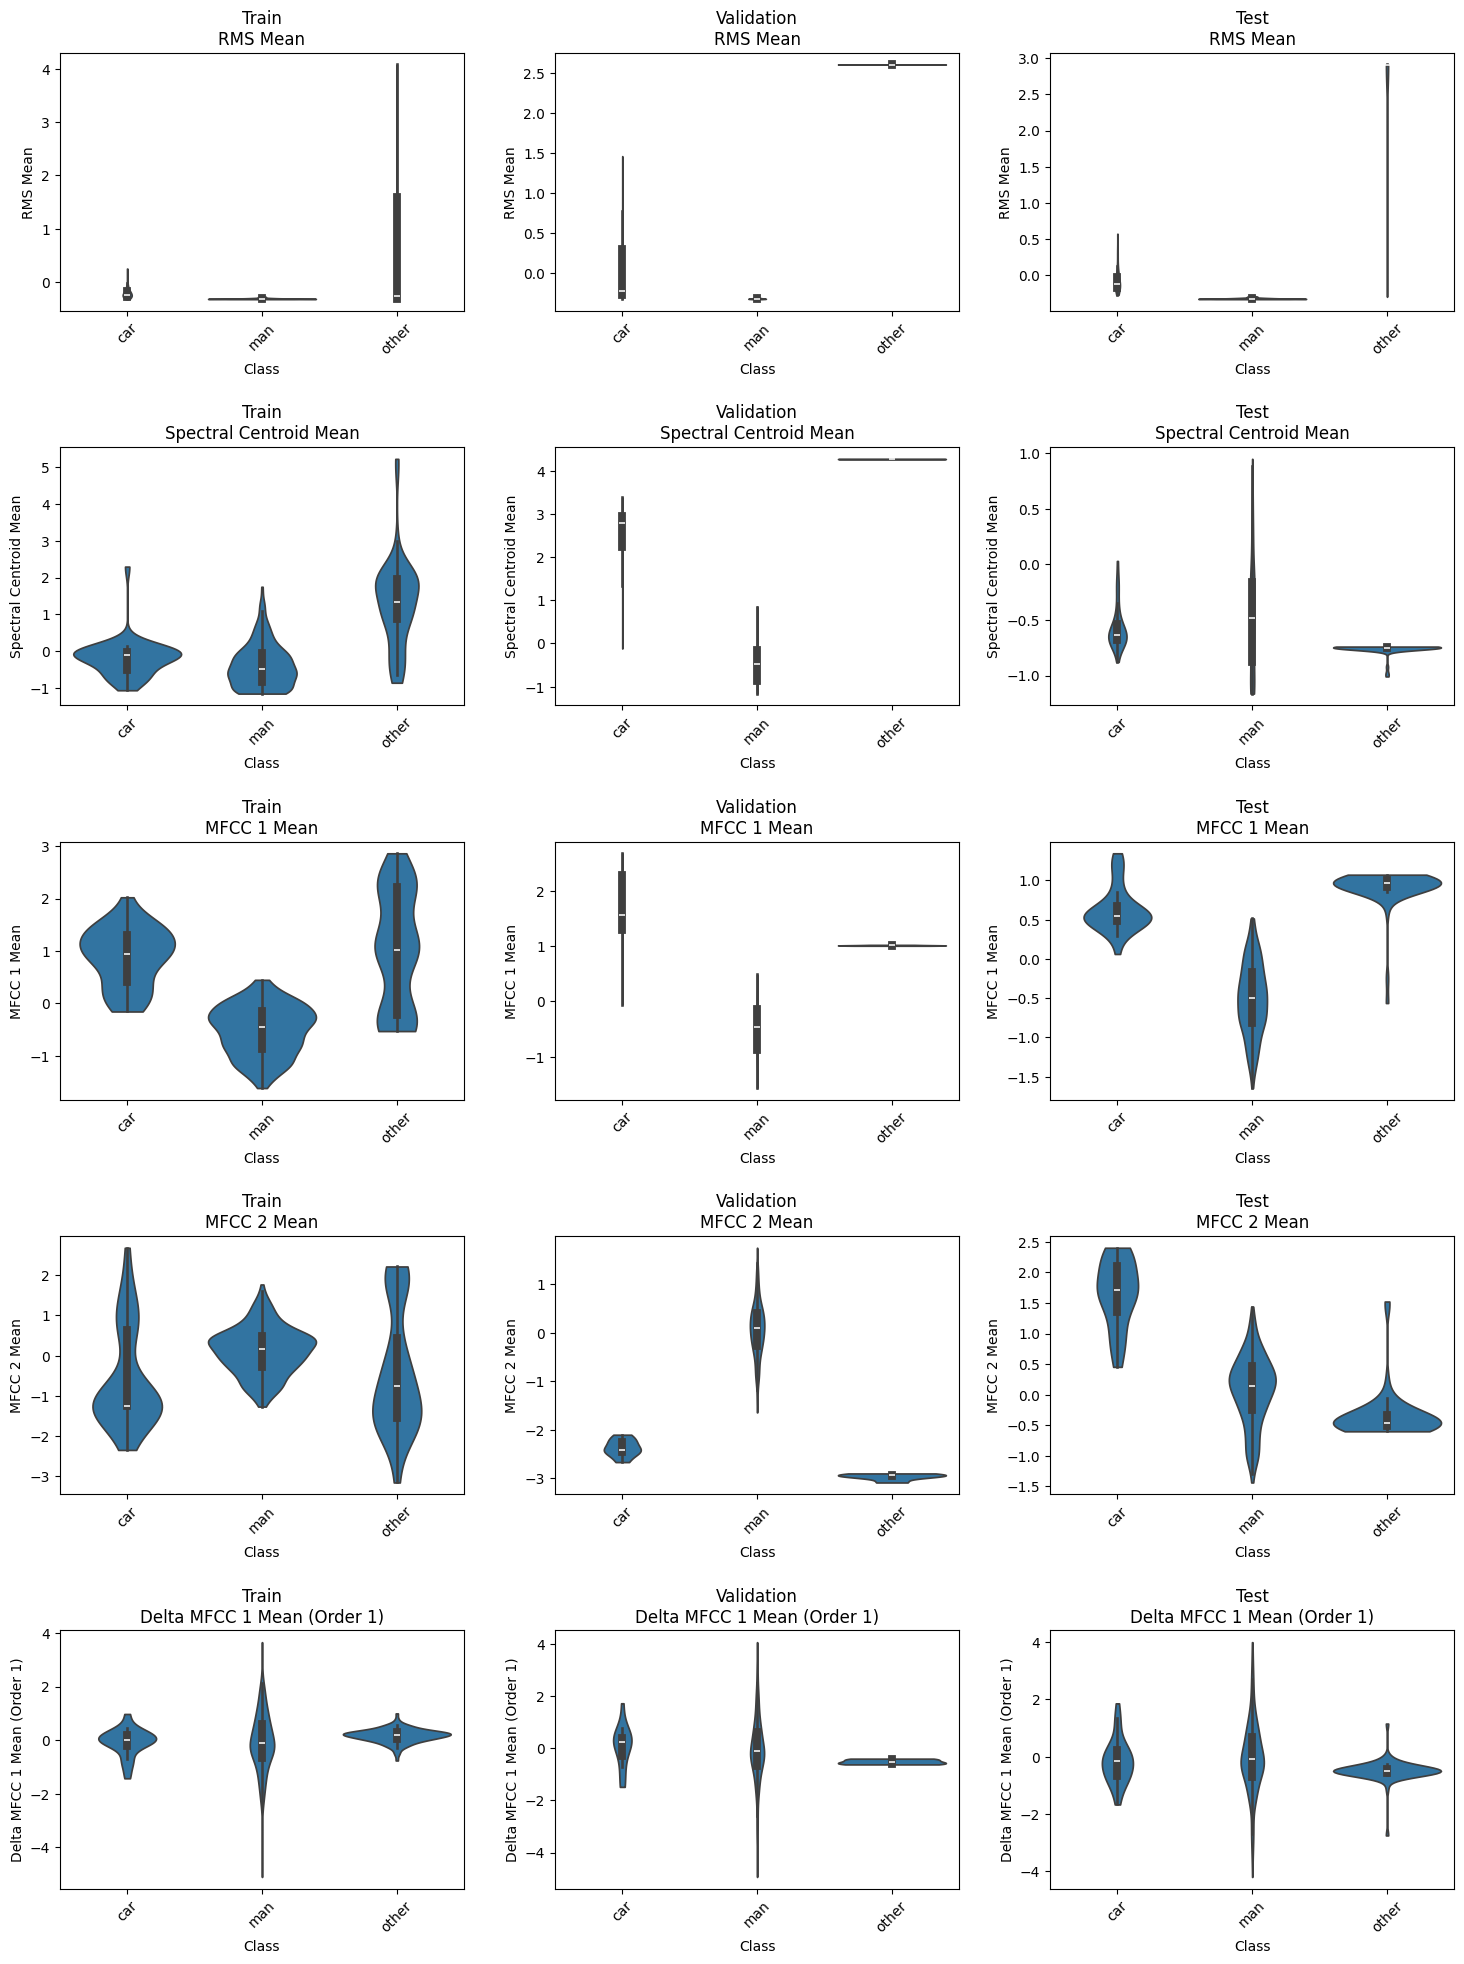


--- Starting Training ---
Epoch 1/100 | LR: 0.000500 | Train loss: 0.4408, acc: 0.8157 | Val loss: 0.1485, acc: 0.9771
  New best validation loss: 0.1485. Saving model state.
Epoch 2/100 | LR: 0.000500 | Train loss: 0.1664, acc: 0.9532 | Val loss: 0.0481, acc: 0.9915
  New best validation loss: 0.0481. Saving model state.
Epoch 3/100 | LR: 0.000500 | Train loss: 0.1011, acc: 0.9696 | Val loss: 0.0395, acc: 0.9920
  New best validation loss: 0.0395. Saving model state.
Epoch 4/100 | LR: 0.000500 | Train loss: 0.0747, acc: 0.9765 | Val loss: 0.0397, acc: 0.9922
  Validation loss did not improve. Patience: 1/10
Epoch 5/100 | LR: 0.000500 | Train loss: 0.0668, acc: 0.9790 | Val loss: 0.0377, acc: 0.9930
  New best validation loss: 0.0377. Saving model state.
Epoch 6/100 | LR: 0.000500 | Train loss: 0.0538, acc: 0.9821 | Val loss: 0.0391, acc: 0.9932
  Validation loss did not improve. Patience: 1/10
Epoch 7/100 | LR: 0.000500 | Train loss: 0.0496, acc: 0.9840 | Val loss: 0.0354, acc: 0.993

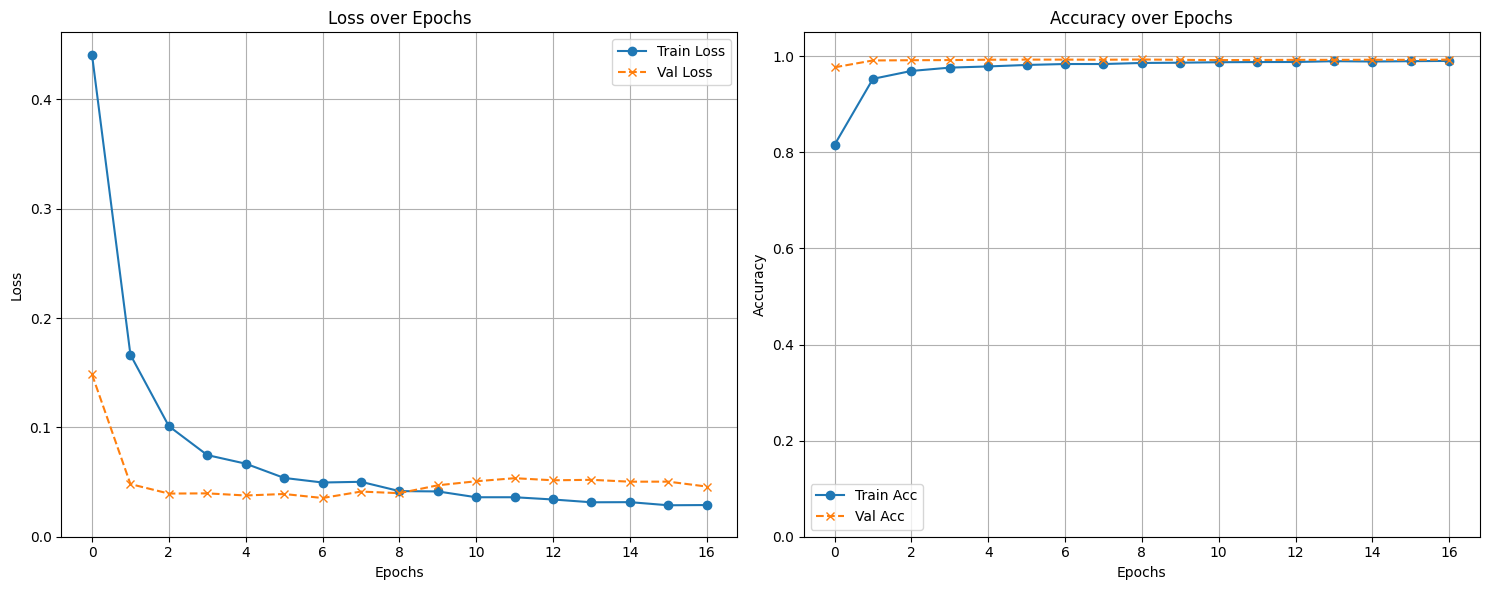


--- Evaluating on Test Set ---
Collected features from test set. Shape: (4889, 125)

Evaluating 4889 test samples...

--- Test Confusion Matrix ---


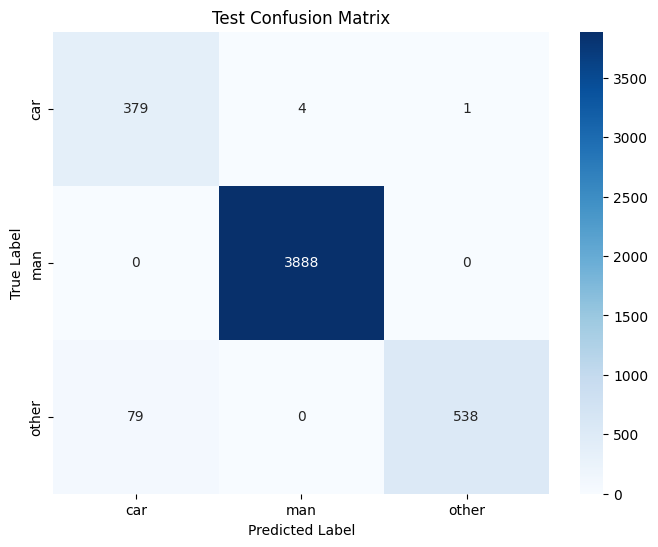


--- Detailed Classification Report (Test Set) ---
              precision    recall  f1-score   support

         car       0.83      0.99      0.90       384
         man       1.00      1.00      1.00      3888
       other       1.00      0.87      0.93       617

    accuracy                           0.98      4889
   macro avg       0.94      0.95      0.94      4889
weighted avg       0.99      0.98      0.98      4889

Overall Test Accuracy: 0.9828

--- Generating t-SNE visualization of Test Set features ---
Running t-SNE on 4889 samples with 125 features...
(This might take a moment...)


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


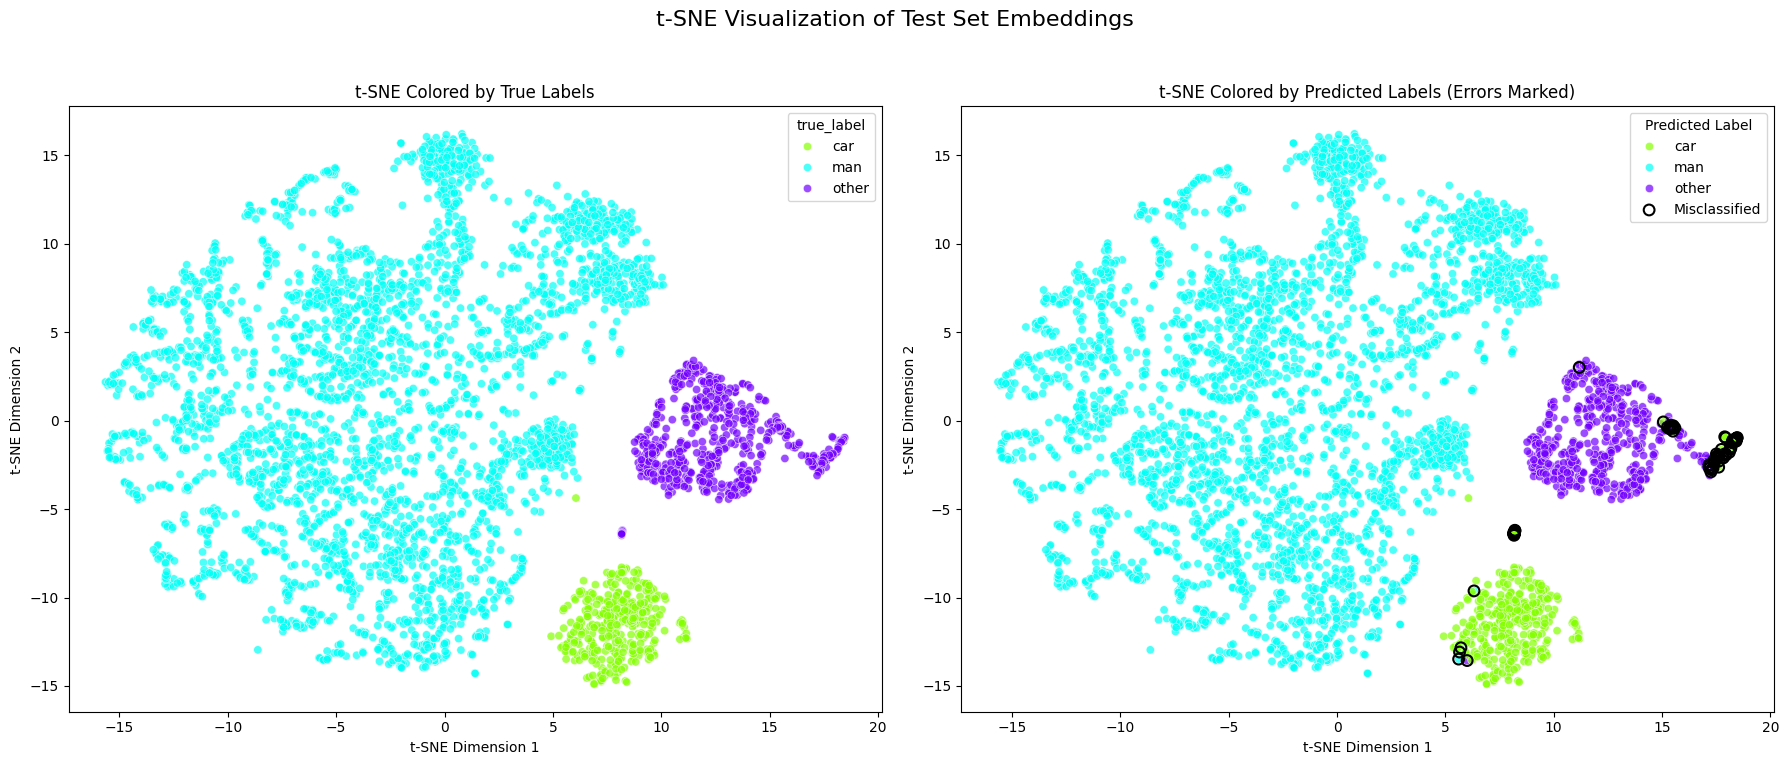


--- End of Script ---


In [31]:
# -*- coding: utf-8 -*-
# --- Libraries ---
import torch, librosa, random, glob, os, time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE # For visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE 
import sklearn 
print(f"PyTorch Version: {torch.__version__}")
print(f"Librosa Version: {librosa.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}") # Add sklearn version print
print(f"Seaborn Version: {sns.__version__}")

# --- Configuration ---
BASE_DATA_DIR = 'DATA' # ודא שהנתיב נכון ומצביע לתיקיית הפרויקט שלך
SEED = 42
SR = 1000.0 # Sample Rate (Hz)
WINDOW_SECONDS = 1 # אורך חלון בשניות
STEP_SECONDS = 0.5      # גודל צעד בין חלונות בשניות
N_MFCC = 20             # מספר מקדמי MFCC
DELTA_ORDER = 2         # כולל דלתא ודלתא-דלתא (1 ו-2)

# --- פרמטרים ל-MFCC המותאמים ל-SR נמוך ---
N_FFT = 256             # גודל חלון FFT (דגימות)
HOP_LENGTH = 64         # גודל צעד בין פריימים (דגימות)
# ----------------------------------------------

AUGMENT_PROB = 0.5      # הסתברות להפעלת אוגמנטציה (הוספת רעש) על חלון אימון
AUGMENT_NOISE_LEVEL = 0.005 # רמת הרעש להוספה

BATCH_SIZE = 128
LR = 0.0005
WEIGHT_DECAY = 1e-5
EPOCHS = 100            # מספר אפוקים מקסימלי
EARLY_STOPPING_PATIENCE = 10 # מספר אפוקים לחכות לשיפור לפני עצירה מוקדמת
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Sample Rate: {SR} Hz")
print(f"Window Size: {WINDOW_SECONDS}s ({int(SR*WINDOW_SECONDS)} samples), Step Size: {STEP_SECONDS}s ({int(SR*STEP_SECONDS)} samples)")
print(f"N_FFT: {N_FFT}, Hop Length: {HOP_LENGTH}")

# --- Seed Everything ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.deterministic = True # יכול להאט אימון, השתמש בזהירות
# torch.backends.cudnn.benchmark = False    # יכול להאט אימון

ALL_CLASSES = ['man', 'car', 'other']
# שימוש ב-LabelEncoder גלובלי ליצירת עקביות (הוא ממיין אלפביתית: 'car', 'man', 'other')
global_le = LabelEncoder().fit(ALL_CLASSES)
CLASS_MAPPING = dict(zip(global_le.classes_, global_le.transform(global_le.classes_)))
print("Class mapping:", CLASS_MAPPING)
NUM_CLASSES = len(ALL_CLASSES)

# --- Load Data ---
def load_csv(fp):
    """Loads a CSV file, handles potential header issues and non-numeric data."""
    try:
        # Try reading with header
        df = pd.read_csv(fp)
        # Ensure all columns are numeric, coerce errors to NaN, then fill with 0
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        return df.fillna(0).values.astype(np.float32)
    except (pd.errors.ParserError, UnicodeDecodeError, ValueError) as e1:
         # print(f"Warning: Reading '{os.path.basename(fp)}' with header failed ({e1}), trying without header.")
         try:
            # Try reading without header
             return pd.read_csv(fp, header=None).apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
         except Exception as e2:
             print(f"ERROR: Failed to load CSV '{fp}': {e2}. Returning empty array.")
             return np.array([[]], dtype=np.float32) # Return a valid empty array

# --- Feature Extraction (with Deltas) ---
def extract_features(window, sr, n_mfcc=N_MFCC, delta_order=DELTA_ORDER, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Extracts features from an audio window, including MFCC deltas."""
    if window.shape[0] < n_fft: # Need at least n_fft samples for STFT
         # print(f"Warning: Window too short ({window.shape[0]} samples) for n_fft={n_fft}. Returning zeros.")
         # Calculate expected output size for zeros
         num_basic_features = 5 # RMS, ZCR, Centroid, Bandwidth, Rolloff (means)
         num_mfcc_features = n_mfcc * 2 # mean + std
         num_delta_features = n_mfcc * 2 * delta_order # mean + std for each delta order
         total_features = num_basic_features + num_mfcc_features + num_delta_features
         return np.zeros(total_features, dtype=np.float32)

    try:
        # Basic features
        rms = librosa.feature.rms(y=window, frame_length=n_fft, hop_length=hop_length)[0]
        zcr = librosa.feature.zero_crossing_rate(y=window, frame_length=n_fft, hop_length=hop_length)[0]

        # Spectral features using STFT with adjusted parameters
        stft_result = librosa.stft(y=window, n_fft=n_fft, hop_length=hop_length)
        S = np.abs(stft_result)**2 # Power spectrogram

        spectral_centroid = librosa.feature.spectral_centroid(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]

        # MFCCs with adjusted parameters
        mfccs = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        # Check if enough frames were generated for delta calculation (default width=9)
        min_frames_for_delta = 9 # Default width for librosa.feature.delta
        if mfccs.shape[1] < min_frames_for_delta:
             # print(f"Warning: Not enough frames ({mfccs.shape[1]}) generated for delta calculation (need {min_frames_for_delta}). Skipping deltas.")
             # Calculate features without deltas
             features = [
                np.mean(rms), np.mean(zcr),
                np.mean(spectral_centroid), np.mean(spectral_bandwidth), np.mean(spectral_rolloff),
                *mfccs.mean(axis=1), *mfccs.std(axis=1)
             ]
             # Pad with zeros for the missing delta features
             num_delta_features = n_mfcc * 2 * delta_order
             features.extend(np.zeros(num_delta_features))

        else:
            # Calculate deltas if enough frames exist
            features = [
                np.mean(rms), np.mean(zcr),
                np.mean(spectral_centroid), np.mean(spectral_bandwidth), np.mean(spectral_rolloff),
                *mfccs.mean(axis=1), *mfccs.std(axis=1)
            ]
            for i in range(1, delta_order + 1):
                delta_mfccs = librosa.feature.delta(mfccs, order=i)
                features.extend(delta_mfccs.mean(axis=1))
                features.extend(delta_mfccs.std(axis=1))

        return np.array(features, dtype=np.float32)

    except Exception as e:
        print(f"ERROR during feature extraction: {e}.")
        print(f"  Window shape: {window.shape}, SR: {sr}, n_fft: {n_fft}, hop_length: {hop_length}")
        if 'mfccs' in locals():
            print(f"  MFCCs shape: {mfccs.shape}")
        print("  Returning zeros.")
        # Calculate expected output size for zeros
        num_basic_features = 5
        num_mfcc_features = n_mfcc * 2
        num_delta_features = n_mfcc * 2 * delta_order
        total_features = num_basic_features + num_mfcc_features + num_delta_features
        return np.zeros(total_features, dtype=np.float32)

# --- Dataset ---
class GeoDataset(Dataset):
    def __init__(self, files_info, scaler=None, fit_scaler=True, sr=SR, window_sec=WINDOW_SECONDS, step_sec=STEP_SECONDS, augment_prob=0.0, noise_level=0.005, is_train=False):
        X, Y = [], []
        self.augment_prob = augment_prob if is_train else 0.0 # Augment only training data
        self.noise_level = noise_level
        self.is_train = is_train
        self.file_origins = [] # To track which file each window came from (for analysis)
        self.window_indices = [] # To track window index within a file

        print(f"\nProcessing dataset ({'TRAIN' if is_train else ('VAL' if not is_train and scaler else 'TEST')})...")
        window_len = int(sr * window_sec)
        step_len = int(sr * step_sec)

        if not files_info:
             print("  Warning: No files provided for this dataset split.")
             # Initialize empty state
             self.X = np.array([], dtype=np.float32).reshape(0, 1) # Placeholder shape
             self.Y = np.array([], dtype=np.int64)
             self.feature_dim = 1 # Placeholder
             if fit_scaler:
                 self.scaler = StandardScaler() # Create dummy scaler
             else:
                 if scaler is None: raise ValueError("Scaler must be provided when fit_scaler=False")
                 self.scaler = scaler
             return

        total_windows_extracted = 0
        files_processed_count = 0
        for fp, lbl in files_info:
            # print(f"  Loading: {os.path.basename(fp)} ({lbl})") # Can be verbose, uncomment if needed
            data = load_csv(fp)
            files_processed_count += 1
            if data.ndim < 2 or data.shape[0] < window_len or data.shape[1] == 0:
                # print(f"    Skipping {os.path.basename(fp)} - insufficient data or load error (shape: {data.shape})")
                continue

            num_sensors = data.shape[1]
            file_window_count = 0
            for sensor_idx in range(num_sensors):
                sensor_data = data[:, sensor_idx]
                for start in range(0, len(sensor_data) - window_len + 1, step_len):
                    win = sensor_data[start : start + window_len]
                    features = extract_features(win, sr)

                    if np.any(np.isnan(features)): # Check for NaNs
                         # print(f"Warning: NaN detected in features for window from {os.path.basename(fp)}. Skipping.")
                         continue
                    if np.all(features == 0): # Check if all features are zero (likely due to short window warning)
                         # print(f"Warning: Zero features detected for window from {os.path.basename(fp)}. Skipping.")
                         continue

                    X.append(features)
                    Y.append(lbl)
                    self.file_origins.append(os.path.basename(fp))
                    self.window_indices.append(start // step_len)
                    file_window_count += 1

            total_windows_extracted += file_window_count
            # if file_window_count == 0:
            #      print(f"    No valid windows extracted from {os.path.basename(fp)} (shape: {data.shape})")

        print(f"  Processed {files_processed_count} files.")
        print(f"  Total valid windows extracted: {total_windows_extracted}")

        # Convert to NumPy array before scaling
        X = np.array(X, dtype=np.float32)

        if X.shape[0] == 0:
             print("  ERROR: No valid features extracted for this dataset split. Dataset will be empty.")
             self.X = np.array([], dtype=np.float32).reshape(0, 1) # Placeholder shape
             self.Y = np.array([], dtype=np.int64)
             self.feature_dim = 1 # Placeholder
             if fit_scaler:
                 self.scaler = StandardScaler()
             else:
                 if scaler is None: raise ValueError("Scaler must be provided when fit_scaler=False")
                 self.scaler = scaler
             return # Exit init

        self.feature_dim = X.shape[1] # Store the feature dimension

        print(f"  Scaling features (shape before scaling: {X.shape})...")
        if fit_scaler:
            self.scaler = StandardScaler()
            self.X = self.scaler.fit_transform(X)
            print(f"  Scaler fit on {X.shape[0]} samples.")
        else:
            if scaler is None:
                raise ValueError("Scaler must be provided when fit_scaler=False")
            self.scaler = scaler
            self.X = self.scaler.transform(X)

        # Encode labels using the global encoder
        self.Y = global_le.transform(Y)

        print(f"Dataset ready. Features shape: {self.X.shape}, Labels shape: {self.Y.shape}")
        if self.X.shape[0] > 0:
            print(f"Feature dimension: {self.feature_dim}")

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        features = self.X[idx]

        # --- Feature-level Augmentation (Noise Injection) ---
        if self.is_train and random.random() < self.augment_prob:
            noise = np.random.normal(0, self.noise_level, features.shape)
            features = features + noise

        label = self.Y[idx]
        # Ensure features are float and labels are long
        return torch.tensor(features).float(), torch.tensor(label).long()

# --- NEW: Data Splitting Logic (Random File-Based) ---

print("\n--- Preparing File Lists ---")
# Define paths relative to BASE_DATA_DIR
man2_path = os.path.join(BASE_DATA_DIR, 'man2')
other_path = os.path.join(BASE_DATA_DIR, 'other')

# Function to get existing files safely using glob patterns
def get_existing_files(patterns):
    files = []
    if isinstance(patterns, str):
        patterns = [patterns] # Allow single pattern string
    for pattern in patterns:
        abs_pattern = os.path.join(BASE_DATA_DIR, pattern) # Construct absolute pattern
        found = glob.glob(abs_pattern)
        # print(f"Globbing pattern: {abs_pattern}, Found: {len(found)} files") # Debug print
        if not found:
            print(f"  Warning: No files found matching pattern: {pattern}")
        # Filter only existing files (glob should handle this, but double check)
        files.extend([f for f in found if os.path.exists(f)])
    return sorted(list(set(files))) # Use set to remove duplicates and sort for consistency

# Get all files per class using relative patterns
all_man_files = get_existing_files([
    os.path.join('man2', '*.csv'), # Files in man2 subdir
    'man.csv'                     # Specific file in base dir
])
all_car_files = get_existing_files([
    'car.csv', 'car2.csv', 'car3.csv', 'car4.csv' # Specific car files in base dir
])
all_other_files = get_existing_files([
    os.path.join('other', '*.csv') # All files in other subdir
])

print(f"Found {len(all_man_files)} 'man' files.")
print(f"Found {len(all_car_files)} 'car' files.")
print(f"Found {len(all_other_files)} 'other' files.")

# --- Splitting Function (File-based) ---
def split_files(file_list, train_ratio=0.7, val_ratio=0.15, seed=SEED):
    """Splits a list of files randomly into train, val, test sets."""
    n = len(file_list)
    if n == 0:
        print("  Warning: Cannot split empty file list.")
        return [], [], []

    # Ensure ratios sum approximately to 1
    test_ratio = 1.0 - train_ratio - val_ratio
    if not (0 <= train_ratio <= 1 and 0 <= val_ratio <= 1 and 0 <= test_ratio <= 1):
         raise ValueError("Ratios must be between 0 and 1 and sum to 1.")

    # Shuffle the list reproducibly
    local_random = random.Random(seed)
    shuffled_list = file_list[:] # Create a copy
    local_random.shuffle(shuffled_list)

    # Calculate split indices
    idx1 = int(train_ratio * n)
    idx2 = int((train_ratio + val_ratio) * n)

    train = shuffled_list[:idx1]
    val = shuffled_list[idx1:idx2]
    test = shuffled_list[idx2:]

    # Handle edge cases for very small lists
    if n > 0 and not train and (val or test): # If train is empty but others aren't
        print(f"  Warning: Train split empty for list of size {n}. Moving one file from val/test to train.")
        if val:
            train = [val.pop(0)]
        elif test:
            train = [test.pop(0)]
    if n > 0 and not val and test and train: # If val is empty but others aren't
         print(f"  Warning: Validation split empty for list of size {n}. Check ratios if this is unexpected.")
         # Decide if you want to move a file, or leave it empty. Leaving empty is often better.
         pass
    # Similar check for test if needed

    print(f"  Splitting {n} files -> Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
    if len(train) + len(val) + len(test) != n:
         print(f"  Warning: Split counts ({len(train)}+{len(val)}+{len(test)}) do not sum to total ({n}). Check logic.")


    return train, val, test

# --- Apply Splitting ---
print("\n--- Splitting Files per Class (70% Train, 15% Val, 15% Test) ---")
train_man_files, val_man_files, test_man_files = split_files(all_man_files, train_ratio=0.7, val_ratio=0.15, seed=SEED)
train_car_files, val_car_files, test_car_files = split_files(all_car_files, train_ratio=0.7, val_ratio=0.15, seed=SEED)
train_other_files, val_other_files, test_other_files = split_files(all_other_files, train_ratio=0.7, val_ratio=0.15, seed=SEED)

# --- Combine Splits and Shuffle ---
# Combine files from different classes for each split
train_files_info = [(f, 'man') for f in train_man_files] + \
                   [(f, 'car') for f in train_car_files] + \
                   [(f, 'other') for f in train_other_files]
val_files_info = [(f, 'man') for f in val_man_files] + \
                 [(f, 'car') for f in val_car_files] + \
                 [(f, 'other') for f in val_other_files]
test_files_info = [(f, 'man') for f in test_man_files] + \
                  [(f, 'car') for f in test_car_files] + \
                  [(f, 'other') for f in test_other_files]

# Shuffle the combined lists to mix classes within each dataset
random.Random(SEED).shuffle(train_files_info)
random.Random(SEED).shuffle(val_files_info)
random.Random(SEED).shuffle(test_files_info)

# Detailed Print of the file split summary:
print("\n--- Data Split Summary (Files) ---")
for name, file_info_list in [('TRAIN', train_files_info), ('VAL', val_files_info), ('TEST', test_files_info)]:
    c = Counter([info[1] for info in file_info_list]) # Count labels in the list
    total_files = len(file_info_list)
    print(f"{name} Set ({total_files} files):")
    if total_files > 0:
         dist_str = ", ".join([f"{lbl}: {count}" for lbl, count in sorted(c.items())])
         print(f"  Distribution: {dist_str}")
         # Print first few file names as example
         # print(f"  Example files: {[os.path.basename(f[0]) for f in file_info_list[:3]]}")
    else:
        print("  Set is EMPTY!")
    if total_files == 0:
        print(f"WARNING: {name} set has 0 files!")


# --- Create Datasets and DataLoaders ---
print("\n--- Creating Datasets and DataLoaders ---")
# Create Train dataset: fit scaler and enable augmentation
train_ds = GeoDataset(train_files_info, fit_scaler=True, is_train=True, augment_prob=AUGMENT_PROB, noise_level=AUGMENT_NOISE_LEVEL)

# Check if train_ds was created successfully and has features
if not hasattr(train_ds, 'scaler') or train_ds.X.shape[0] == 0:
     raise ValueError("Training dataset creation failed or resulted in zero samples. Cannot proceed.")

# Use the scaler from the training set for Val and Test sets
scaler = train_ds.scaler
val_ds = GeoDataset(val_files_info, scaler=scaler, fit_scaler=False, is_train=False)
test_ds = GeoDataset(test_files_info, scaler=scaler, fit_scaler=False, is_train=False)

# Check for feature dimension consistency (important if datasets were processed differently)
if hasattr(val_ds, 'feature_dim') and val_ds.X.shape[0] > 0 and val_ds.feature_dim != train_ds.feature_dim:
     print(f"Warning: Feature dimension mismatch between TRAIN ({train_ds.feature_dim}) and VAL ({val_ds.feature_dim})")
if hasattr(test_ds, 'feature_dim') and test_ds.X.shape[0] > 0 and test_ds.feature_dim != train_ds.feature_dim:
     print(f"Warning: Feature dimension mismatch between TRAIN ({train_ds.feature_dim}) and TEST ({test_ds.feature_dim})")


# --- Create DataLoaders ---
# Ensure datasets have data before creating loaders
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=0) if len(train_ds) > 0 else None
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=0) if len(val_ds) > 0 else None
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False, num_workers=0) if len(test_ds) > 0 else None

if not train_loader: print("Warning: Training DataLoader could not be created (empty dataset).")
if not val_loader: print("Warning: Validation DataLoader could not be created (empty dataset).")
if not test_loader: print("Warning: Test DataLoader could not be created (empty dataset).")


# --- Compute Class Weights based on TRAIN distribution ---
weights_tensor = None
if train_loader:
    train_counts = Counter(train_ds.Y) # Counts based on encoded labels (0, 1, 2...)
    total_windows = len(train_ds.Y)
    print("\n--- Class Weights Calculation (based on TRAIN windows) ---")
    if total_windows > 0:
        # Check if all classes are present in the training set windows
        if len(train_counts) == NUM_CLASSES:
            # Calculate weights: weight = total_samples / (num_classes * count_for_class)
            # Or simpler: weight = max_count / count_for_class
            # Using: total_windows / count_for_class (can lead to large weights for rare classes)
            weights = []
            print("Class counts (Train windows):", dict(sorted(train_counts.items())))
            max_count = max(train_counts.values()) if train_counts else 1 # Avoid division by zero if empty
            # Smoothed weighting: total / (count + epsilon) or max_count / count
            for i in range(NUM_CLASSES):
                 count = train_counts.get(i, 0) # Get count for class index i
                 # Option 1: Inverse count
                 # weight = total_windows / (count + 1e-6) # Add epsilon to avoid division by zero
                 # Option 2: Inverse frequency scaled by max frequency
                 weight = max_count / (count + 1e-6) if count > 0 else max_count # Give max weight if class is missing? Or 1? Let's use max_count/count
                 weights.append(weight)

            weights_tensor = torch.FloatTensor(weights).to(DEVICE)
            print("Calculated weights:", [round(w.item(), 4) for w in weights_tensor])
            criterion = nn.CrossEntropyLoss(weight=weights_tensor)
            print("Using weighted CrossEntropyLoss.")
        else:
             print(f"Warning: Only {len(train_counts)}/{NUM_CLASSES} classes present in training set windows.")
             print("Class counts (Train windows):", dict(sorted(train_counts.items())))
             print("Using unweighted CrossEntropyLoss.")
             criterion = nn.CrossEntropyLoss()
    else:
         print("Warning: Training set is empty. Using unweighted CrossEntropyLoss.")
         criterion = nn.CrossEntropyLoss()

else:
    print("Skipping class weight calculation as train_loader is not available.")
    criterion = nn.CrossEntropyLoss() # Default unweighted loss

# --- Model (with BatchNorm) ---
# Ensure feature dimension is correctly obtained from the dataset
if not hasattr(train_ds, 'feature_dim'):
     raise ValueError("Could not determine feature dimension from training dataset.")
INPUT_DIM = train_ds.feature_dim
print(f"\nInput feature dimension for the model: {INPUT_DIM}")

model = nn.Sequential(
    nn.Linear(INPUT_DIM, 128),
    nn.BatchNorm1d(128), # Add BatchNorm after Linear, before activation
    nn.ReLU(),
    nn.Dropout(0.5),     # Dropout after activation
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, NUM_CLASSES) # Output layer size = number of classes
).to(DEVICE)

print("\n--- Model Architecture ---")
print(model)

# Optimizer (AdamW includes weight decay)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# Learning Rate Scheduler (Optional, but recommended for stability)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


# --- Helper Function to Print Window Distribution ---
def print_windows_distribution(dataset, dataset_name):
    """Prints the distribution of classes based on window counts in a dataset."""
    if not hasattr(dataset, 'Y') or len(dataset.Y) == 0:
        print(f"\nWindow Distribution in {dataset_name}: Dataset is EMPTY or has no labels.")
        return
    try:
        counts = Counter(dataset.Y) # Counts based on encoded labels (0, 1, 2...)
        total_windows = sum(counts.values())
        # Convert numeric labels back to class names for printing
        distribution = {global_le.inverse_transform([idx])[0]: count for idx, count in sorted(counts.items())}
        print(f"\n--- Window Distribution in {dataset_name} ({total_windows} total windows) ---")
        for label, count in distribution.items():
            print(f"  {label}: {count} ({count/total_windows*100:.1f}%)")
    except Exception as e:
         print(f"Error printing distribution for {dataset_name}: {e}")
         # print(f"Raw counts: {counts}") # Uncomment for debugging if needed


# Print window distributions for the newly created datasets
print_windows_distribution(train_ds, "TRAIN")
print_windows_distribution(val_ds, "VAL")
print_windows_distribution(test_ds, "TEST")


# --- Feature Distribution Visualization Function ---
def plot_feature_distributions(datasets, dataset_names, feature_indices, feature_names, n_samples=500):
    """Plots violin plots for selected features across different datasets."""
    print("\n--- Plotting Feature Distributions ---")
    num_features_to_plot = len(feature_indices)
    num_datasets = len(datasets)
    if num_features_to_plot == 0 or num_datasets == 0:
        print("No features or datasets to plot.")
        return

    fig, axes = plt.subplots(num_features_to_plot, num_datasets,
                             figsize=(5 * num_datasets, 4 * num_features_to_plot),
                             squeeze=False) # Ensure axes is always 2D array

    for i, (ds, ds_name) in enumerate(zip(datasets, dataset_names)):
        if not hasattr(ds, 'X') or ds.X.shape[0] == 0:
            print(f"Skipping plotting for empty or invalid dataset: {ds_name}")
            # Draw empty plot with text
            for j in range(num_features_to_plot):
                 axes[j, i].text(0.5, 0.5, 'Dataset Empty', horizontalalignment='center', verticalalignment='center', transform=axes[j, i].transAxes)
                 axes[j, i].set_title(f"{ds_name}\n{feature_names[j]}")
                 axes[j, i].set_xticks([])
                 axes[j, i].set_yticks([])
            continue

        # Sample data for plotting efficiency
        n_total = ds.X.shape[0]
        indices = np.arange(n_total)
        np.random.shuffle(indices)
        sample_indices = indices[:min(n_samples, n_total)]

        X_sample = ds.X[sample_indices]
        Y_sample = ds.Y[sample_indices] # Encoded labels
        labels_sample = global_le.inverse_transform(Y_sample) # Get class names

        df_list = []
        for j, feature_idx in enumerate(feature_indices):
             if feature_idx < ds.X.shape[1]:
                 feature_col_name = feature_names[j]
                 temp_df = pd.DataFrame({
                     'value': X_sample[:, feature_idx],
                     'label': labels_sample,
                     'feature': feature_col_name # Add feature name column
                 })
                 df_list.append(temp_df)
             else:
                  print(f"Warning: Feature index {feature_idx} out of bounds for {ds_name} (dim={ds.X.shape[1]})")

        if not df_list:
             print(f"No valid features to plot for {ds_name}")
             continue

        # Combine data for plotting
        # df_plot = pd.concat(df_list) # This combines all features into one plot per dataset, maybe not desired. Plot individually.

        for j, feature_name in enumerate(feature_names):
             # Find the corresponding feature index
             feature_idx = feature_indices[j]
             if feature_idx < ds.X.shape[1]:
                 # Create df for this specific feature
                 df_feature = pd.DataFrame({
                     feature_name: X_sample[:, feature_idx], # Use the actual feature name as column
                     'label': labels_sample
                 })
                 # Plot violin plot for this feature
                 sns.violinplot(x='label', y=feature_name, data=df_feature, ax=axes[j, i], order=global_le.classes_, cut=0) # cut=0 avoids extending beyond data range
                 axes[j, i].set_title(f"{ds_name}\n{feature_name}")
                 axes[j, i].set_xlabel("Class")
                 axes[j, i].tick_params(axis='x', rotation=45)
             else:
                 # Feature index was out of bounds, show empty plot
                  axes[j, i].text(0.5, 0.5, f'Feature Idx {feature_idx}\nOut of Bounds', horizontalalignment='center', verticalalignment='center', transform=axes[j, i].transAxes)
                  axes[j, i].set_title(f"{ds_name}\n{feature_names[j]}")
                  axes[j, i].set_xticks([])
                  axes[j, i].set_yticks([])


    plt.tight_layout(pad=2.0) # Add some padding
    plt.show()

# Select features to plot (Indices based on `extract_features` output order)
# 0:RMS, 1:ZCR, 2:Centroid, 3:Bandwidth, 4:Rolloff
# 5 to 5+N_MFCC-1: MFCC means
# 5+N_MFCC to 5+2*N_MFCC-1: MFCC stds
# 5+2*N_MFCC to 5+3*N_MFCC-1: Delta MFCC means (Order 1)
# 5+3*N_MFCC to 5+4*N_MFCC-1: Delta MFCC stds (Order 1)
# 5+4*N_MFCC to 5+5*N_MFCC-1: Delta-Delta MFCC means (Order 2)
# 5+5*N_MFCC to 5+6*N_MFCC-1: Delta-Delta MFCC stds (Order 2)
features_to_plot_indices = [
    0,                      # RMS Mean
    2,                      # Spectral Centroid Mean
    5 + 0,                  # MFCC 1 Mean
    5 + 1,                  # MFCC 2 Mean
    5 + 2*N_MFCC + 0        # Delta MFCC 1 Mean (Order 1)
]
features_to_plot_names = [
    'RMS Mean',
    'Spectral Centroid Mean',
    'MFCC 1 Mean',
    'MFCC 2 Mean',
    f'Delta MFCC 1 Mean (Order 1)'
]

# Check if selected indices are valid for the determined feature dimension
if hasattr(train_ds, 'feature_dim'):
    valid_indices = [i for i in features_to_plot_indices if i < train_ds.feature_dim]
    valid_names = [features_to_plot_names[features_to_plot_indices.index(i)] for i in valid_indices]

    if valid_indices:
         plot_feature_distributions([train_ds, val_ds, test_ds],
                                    ['Train', 'Validation', 'Test'],
                                    valid_indices, valid_names)
    else:
         print("Warning: No valid feature indices selected for plotting distribution based on determined feature dimension.")
else:
    print("Warning: Cannot plot feature distributions, feature dimension not determined.")


# --- Training Loop with Early Stopping and LR Scheduling ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# Check if dataloaders are valid before starting training
if not train_loader or not val_loader:
    print("\nERROR: Cannot start training without valid train and validation dataloaders.")
else:
    print("\n--- Starting Training ---")
    start_time = time.time()

    for epoch in range(EPOCHS):
        # --- Training Phase ---
        model.train()
        loss_t, acc_t, samples_t = 0.0, 0.0, 0 # Use floats for accumulation
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x) # Predicted logits
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            loss_t += loss.item() * y.size(0) # Accumulate loss scaled by batch size
            acc_t += (pred.argmax(1) == y).sum().item() # Accumulate correct predictions count
            samples_t += y.size(0) # Accumulate number of samples processed

        # Calculate epoch metrics only if samples were processed
        train_loss_epoch = loss_t / samples_t if samples_t > 0 else 0
        train_acc_epoch = acc_t / samples_t if samples_t > 0 else 0
        history['train_loss'].append(train_loss_epoch)
        history['train_acc'].append(train_acc_epoch)

        # --- Validation Phase ---
        model.eval()
        loss_v, acc_v, samples_v = 0.0, 0.0, 0
        with torch.no_grad(): # Disable gradient calculation
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)
                loss_v += criterion(pred, y).item() * y.size(0) # Use the same criterion
                acc_v += (pred.argmax(1) == y).sum().item()
                samples_v += y.size(0)

        # Calculate epoch metrics only if validation samples exist
        val_loss_epoch = loss_v / samples_v if samples_v > 0 else float('inf') # Treat no validation data as infinite loss
        val_acc_epoch = acc_v / samples_v if samples_v > 0 else 0
        history['val_loss'].append(val_loss_epoch)
        history['val_acc'].append(val_acc_epoch)

        # Get current learning rate for printing
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.6f} | Train loss: {train_loss_epoch:.4f}, acc: {train_acc_epoch:.4f} | Val loss: {val_loss_epoch:.4f}, acc: {val_acc_epoch:.4f}")

        # --- Early Stopping and Model Checkpointing ---
        if val_loss_epoch != float('inf'): # Perform checks only if validation loss is valid
            # Step the LR scheduler based on validation loss
            scheduler.step(val_loss_epoch)

            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                # Save a deep copy of the model's state dict
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
                print(f"  New best validation loss: {best_val_loss:.4f}. Saving model state.")
            else:
                patience_counter += 1
                print(f"  Validation loss did not improve. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1} after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
                break
        else:
            print("  Skipping early stopping and LR scheduler step as validation loss is invalid (likely empty validation set).")
            # Decide behavior: continue training, stop, etc. Currently continues.

    # --- End of Training ---
    end_time = time.time()
    print(f"--- Training Finished in {(end_time - start_time)/60:.2f} minutes ---")

    # Load the best model state found during training
    if best_model_state is not None:
        print("Loading best model state based on validation loss.")
        model.load_state_dict(best_model_state)
    else:
        print("Warning: No best model state saved (either no improvement or no validation data). Using the last model state.")

    # --- Plot Training History ---
    print("\n--- Plotting Training History ---")
    epochs_ran = len(history['train_loss']) # Actual number of epochs run
    if epochs_ran > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)) # Wider figure

        # Plot Loss
        ax1.plot(range(epochs_ran), history['train_loss'], label='Train Loss', marker='o', linestyle='-')
        # Plot val loss only if it's not infinity
        valid_val_loss = [l if l != float('inf') else None for l in history['val_loss']] # Replace inf with None for plotting
        ax1.plot(range(epochs_ran), valid_val_loss, label='Val Loss', marker='x', linestyle='--')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss over Epochs')
        ax1.legend()
        ax1.grid(True)
        ax1.set_ylim(bottom=0) # Loss typically non-negative

        # Plot Accuracy
        ax2.plot(range(epochs_ran), history['train_acc'], label='Train Acc', marker='o', linestyle='-')
        ax2.plot(range(epochs_ran), history['val_acc'], label='Val Acc', marker='x', linestyle='--')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy over Epochs')
        ax2.legend()
        ax2.grid(True)
        ax2.set_ylim(0, 1.05) # Accuracy between 0 and 1

        plt.tight_layout()
        plt.show()
    else:
        print("No training history to plot.")

# --- Test Phase ---
print("\n--- Evaluating on Test Set ---")
if test_loader:
    model.eval() # Set model to evaluation mode
    all_preds, all_true = [], []
    all_features_test = [] # To collect features for t-SNE

    with torch.no_grad(): # Disable gradient calculations for inference
        for x, y in test_loader:
            # Store features (on CPU) BEFORE moving data to device
            all_features_test.append(x.numpy())

            # Move data to the computation device
            x = x.to(DEVICE)
            y = y.to(DEVICE) # Keep true labels on device for potential loss calculation if needed

            outputs = model(x) # Get model predictions (logits)
            preds = outputs.argmax(1).cpu().numpy() # Get predicted class indices, move to CPU

            all_preds.extend(preds)
            all_true.extend(y.cpu().numpy()) # Move true labels to CPU

    # Concatenate all features collected from batches
    if all_features_test:
         all_features_test = np.concatenate(all_features_test, axis=0)
         print(f"Collected features from test set. Shape: {all_features_test.shape}")
    else:
         print("Warning: No features collected from the test set.")


    # --- Evaluate Predictions ---
    if len(all_true) > 0 and len(all_preds) == len(all_true):
        print(f"\nEvaluating {len(all_true)} test samples...")
        # Convert numeric labels back to original class names using the global encoder
        true_labels_named = global_le.inverse_transform(all_true)
        pred_labels_named = global_le.inverse_transform(all_preds)
        class_names = global_le.classes_ # Get class names in the correct order

        # --- Confusion Matrix ---
        print("\n--- Test Confusion Matrix ---")
        cm = confusion_matrix(all_true, all_preds, labels=global_le.transform(class_names)) # Ensure labels order
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Test Confusion Matrix')
        plt.show()

        # --- Classification Report ---
        print("\n--- Detailed Classification Report (Test Set) ---")
        report = classification_report(all_true, all_preds,
                                       target_names=class_names, zero_division=0,
                                       labels=global_le.transform(class_names)) # Ensure labels order
        print(report)

        # --- Overall Accuracy ---
        accuracy = accuracy_score(all_true, all_preds)
        print(f'Overall Test Accuracy: {accuracy:.4f}')

        # --- t-SNE Visualization of Test Set Features ---
        if all_features_test.shape[0] > 1: # Need more than 1 sample for t-SNE
             print("\n--- Generating t-SNE visualization of Test Set features ---")
             print(f"Running t-SNE on {all_features_test.shape[0]} samples with {all_features_test.shape[1]} features...")
             print("(This might take a moment...)")

             # Dynamically adjust perplexity based on sample size
             n_samples_tsne = all_features_test.shape[0]
             perplexity_tsne = min(30.0, max(5.0, n_samples_tsne / 4.0)) # Common heuristic
             # Ensure perplexity is valid (less than n_samples - 1)
             if perplexity_tsne >= n_samples_tsne -1:
                  perplexity_tsne = max(1.0, n_samples_tsne - 2.0) # Adjust if too high
                  print(f"  Adjusted t-SNE perplexity to {perplexity_tsne:.1f} due to small sample size.")

             if n_samples_tsne > perplexity_tsne + 1 : # Check if enough samples for chosen perplexity
                 tsne = TSNE(n_components=2, random_state=SEED,
                             perplexity=perplexity_tsne, n_iter=350, # Increased iterations slightly
                             init='pca', learning_rate='auto') # Use PCA init and auto LR

                 try:
                     tsne_results = tsne.fit_transform(all_features_test) # Use collected features

                     # Create DataFrame for easier plotting with Seaborn
                     df_tsne = pd.DataFrame({
                         'tsne-2d-one': tsne_results[:,0],
                         'tsne-2d-two': tsne_results[:,1],
                         'true_label': true_labels_named, # Use class names
                         'predicted_label': pred_labels_named, # Use class names
                         'is_correct': [t == p for t, p in zip(true_labels_named, pred_labels_named)]
                     })

                     plt.figure(figsize=(18, 8)) # Wider figure for side-by-side plots

                     # Plot 1: Colored by True Labels
                     ax1 = plt.subplot(1, 2, 1)
                     sns.scatterplot(
                         x="tsne-2d-one", y="tsne-2d-two",
                         hue="true_label",
                         hue_order=class_names, # Ensure consistent color order
                         palette=sns.color_palette("hsv", len(class_names)), # Use distinct colors
                         data=df_tsne,
                         legend="full",
                         alpha=0.7,
                         ax=ax1
                     )
                     ax1.set_title('t-SNE Colored by True Labels')
                     ax1.set_xlabel('t-SNE Dimension 1')
                     ax1.set_ylabel('t-SNE Dimension 2')

                     # Plot 2: Colored by Predicted Labels, marking errors
                     ax2 = plt.subplot(1, 2, 2)
                     # Plot all points colored by prediction
                     sns.scatterplot(
                         x="tsne-2d-one", y="tsne-2d-two",
                         hue="predicted_label",
                         hue_order=class_names, # Ensure consistent color order
                         palette=sns.color_palette("hsv", len(class_names)),
                         data=df_tsne,
                         legend="full",
                         alpha=0.7,
                         ax=ax2
                     )
                     # Mark misclassified points with black circles
                     errors_df = df_tsne[~df_tsne['is_correct']]
                     if not errors_df.empty:
                          ax2.scatter(errors_df['tsne-2d-one'], errors_df['tsne-2d-two'],
                                      s=60, facecolors='none', edgecolors='black', linewidth=1.5, label='Misclassified')
                          # Update legend to include Misclassified marker if errors exist
                          handles, labels = ax2.get_legend_handles_labels()
                          # Find the Misclassified handle/label if added, otherwise add it manually
                          if 'Misclassified' not in labels:
                               from matplotlib.lines import Line2D
                               handles.append(Line2D([0], [0], marker='o', color='w', label='Misclassified',
                                                    markerfacecolor='none', markeredgecolor='black', markersize=8))
                               labels.append('Misclassified')
                          ax2.legend(handles=handles, labels=labels, title='Predicted Label')


                     ax2.set_title('t-SNE Colored by Predicted Labels (Errors Marked)')
                     ax2.set_xlabel('t-SNE Dimension 1')
                     ax2.set_ylabel('t-SNE Dimension 2')


                     plt.suptitle('t-SNE Visualization of Test Set Embeddings', fontsize=16)
                     plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
                     plt.show()

                 except Exception as e:
                     print(f"Could not generate t-SNE plot: {e}")
                     # import traceback
                     # traceback.print_exc() # Print detailed traceback for debugging

             else:
                  print(f"Skipping t-SNE: Not enough samples ({n_samples_tsne}) for the minimum required samples with perplexity ({perplexity_tsne:.1f}). Need at least {int(perplexity_tsne) + 2}.")
        else:
            print("Skipping t-SNE: Not enough test samples or features collected.")

    else:
        print("No predictions generated for the test set (dataset might be empty or an error occurred). Skipping evaluation metrics and plots.")

else:
    print("Test loader is not available (Test dataset might be empty). Skipping test phase.")

print("\n--- End of Script ---")

In [51]:
# -*- coding: utf-8 -*-
# ==============================================================================
#                             Libraries & Setup
# ==============================================================================
import torch
import librosa
import random
import glob
import os
import time
import joblib  # Used by Optuna for some storage aspects, good to have
import sqlite3 # Used by Optuna storage
import warnings

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.manifold import TSNE
import sklearn # For version print
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path # For easier path handling

import optuna # Import Optuna

# --- Audio Augmentations ---
try:
    from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain
    print("Audiomentations library found.")
    audiomentations_available = True
except ImportError:
    print("WARNING: Audiomentations library not found. Consider running: pip install audiomentations")
    print("         Proceeding without audio-level augmentations.")
    audiomentations_available = False

# --- Version Prints ---
print(f"PyTorch Version: {torch.__version__}")
print(f"Librosa Version: {librosa.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
if optuna: print(f"Optuna Version: {optuna.__version__}")

# --- Suppress Specific Librosa Warning ---
# Suppress the specific UserWarning from librosa about n_fft size comparison
warnings.filterwarnings("ignore", message=".*n_fft=.*is too large for input signal.*", category=UserWarning, module="librosa.core.spectrum")
# warnings.filterwarnings("ignore", category=UserWarning) # More general suppression if needed

# ==============================================================================
#                             Configuration
# ==============================================================================
BASE_DATA_DIR = 'DATA'               # Make sure this points to your DATA directory
RESULTS_DIR = Path("optuna_results") # Directory to save results (models, database)
N_BEST_MODELS = 10                   # How many top models to save based on validation F1
OPTIMIZATION_TIMEOUT = 12 * 60 * 60  # 12 hours in seconds

SEED = 42
SR = 1000.0                          # Sample Rate (Hz)
WINDOW_SECONDS = 1.0                 # Window length in seconds (using shorter window)
STEP_SECONDS = 0.5                   # Step size in seconds (using shorter step)
N_MFCC = 20                          # Number of MFCC coefficients
DELTA_ORDER = 2                      # Include delta and delta-delta (1 and 2)
N_FFT = 256                          # FFT window size (samples)
HOP_LENGTH = 64                      # Hop length for STFT/MFCC (samples)

# --- Fixed Training Parameters for HPO Trials ---
EPOCHS_PER_TRIAL = 50                # Max epochs for EACH Optuna trial
EARLY_STOPPING_PATIENCE_TRIAL = 10   # Patience for Early Stopping WITHIN a trial
BATCH_SIZE = 128                     # Fixed batch size during HPO

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ==============================================================================
#                             Global Setup & Seeding
# ==============================================================================
RESULTS_DIR.mkdir(parents=True, exist_ok=True) # Create results directory if it doesn't exist
ALL_CLASSES = ['man', 'car', 'other']
global_le = LabelEncoder().fit(ALL_CLASSES)
CLASS_MAPPING = dict(zip(global_le.classes_, global_le.transform(global_le.classes_)))
NUM_CLASSES = len(ALL_CLASSES)
print("Class mapping:", CLASS_MAPPING)

# --- Seed Everything Function ---
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED) # Seed globally once at the start

# ==============================================================================
#                             Data Loading & Feature Extraction
# ==============================================================================

def load_csv(fp):
    """Loads a CSV file, handles potential header/numeric issues."""
    try:
        df = pd.read_csv(fp)
        for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
        return df.fillna(0).values.astype(np.float32)
    except (pd.errors.ParserError, UnicodeDecodeError, ValueError):
         try: return pd.read_csv(fp, header=None).apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
         except Exception as e2: print(f"ERROR loading {fp}: {e2}"); return np.array([[]], dtype=np.float32)

def extract_features(window, sr, n_mfcc=N_MFCC, delta_order=DELTA_ORDER, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Extracts features (RMS, ZCR, Spectral, MFCCs, Deltas) from an audio window."""
    # --- DEBUG PRINT (Comment out for long runs) ---
    # print(f"DEBUG: extract_features called with n_fft={n_fft}, window length={len(window)}")
    # --- END DEBUG ---
    if window.shape[0] < n_fft:
        num_basic, num_mfcc, num_delta = 5, n_mfcc * 2, n_mfcc * 2 * delta_order
        return np.zeros(num_basic + num_mfcc + num_delta, dtype=np.float32)
    try:
        rms = librosa.feature.rms(y=window, frame_length=n_fft, hop_length=hop_length)[0]
        zcr = librosa.feature.zero_crossing_rate(y=window, frame_length=n_fft, hop_length=hop_length)[0]
        stft_result = librosa.stft(y=window, n_fft=n_fft, hop_length=hop_length); S = np.abs(stft_result)**2
        sp_cent = librosa.feature.spectral_centroid(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        sp_bw = librosa.feature.spectral_bandwidth(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        sp_roll = librosa.feature.spectral_rolloff(S=S, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        mfccs = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        features = [np.mean(rms), np.mean(zcr), np.mean(sp_cent), np.mean(sp_bw), np.mean(sp_roll)]
        min_frames = 9 # Default width for librosa.feature.delta
        if mfccs.shape[1] < min_frames:
            features.extend(mfccs.mean(axis=1)); features.extend(mfccs.std(axis=1))
            features.extend(np.zeros(n_mfcc * 2 * delta_order)) # Pad delta features
        else:
            features.extend(mfccs.mean(axis=1)); features.extend(mfccs.std(axis=1))
            for i in range(1, delta_order + 1):
                delta_mfccs = librosa.feature.delta(mfccs, order=i)
                features.extend(delta_mfccs.mean(axis=1)); features.extend(delta_mfccs.std(axis=1))
        return np.array(features, dtype=np.float32)
    except Exception as e:
        # print(f"ERROR during feature extraction: {e}. Window shape: {window.shape}. Returning zeros.") # Reduce verbosity
        num_basic, num_mfcc, num_delta = 5, n_mfcc * 2, n_mfcc * 2 * delta_order
        return np.zeros(num_basic + num_mfcc + num_delta, dtype=np.float32)

# ==============================================================================
#                             Dataset Class (with Augmentation)
# ==============================================================================
class GeoDataset(Dataset):
    def __init__(self, files_info, scaler=None, fit_scaler=True, sr=SR, window_sec=WINDOW_SECONDS, step_sec=STEP_SECONDS,
                 is_train=False, augment_params=None):
        X, Y = [], []
        self.is_train = is_train
        self.augment_params = augment_params if is_train and augment_params else {}
        self.feature_noise_level = self.augment_params.get('feature_noise_level', 0.0) # Default 0 if not training/no params
        self.feature_augment_prob = self.augment_params.get('feature_augment_prob', 0.0) # Default 0

        # print(f"\nProcessing dataset ({'TRAIN' if is_train else ('VAL' if not is_train and scaler else 'TEST')})...") # Reduce verbosity
        window_len = int(sr * window_sec)
        step_len = int(sr * step_sec)

        # --- Define Audio Augmentation Pipeline (using trial params) ---
        self.audio_augmenter = None
        if self.is_train and audiomentations_available and self.augment_params:
            try:
                self.audio_augmenter = Compose([
                    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.010, p=self.augment_params.get('audio_noise_p', 0.0)), # Use specific probs if tuned
                    TimeStretch(min_rate=0.9, max_rate=1.1, p=self.augment_params.get('audio_stretch_p', 0.0), leave_length_unchanged=False),
                    PitchShift(min_semitones=-1.5, max_semitones=1.5, p=self.augment_params.get('audio_pitch_p', 0.0)),
                    Shift(min_shift=-0.2, max_shift=0.2, p=self.augment_params.get('audio_shift_p', 0.0)), # Corrected params
                    Gain(min_gain_db=-3.0, max_gain_db=3.0, p=self.augment_params.get('audio_gain_p', 0.0)), # Corrected params
                ])
                # print("Audio augmentation pipeline created.") # Reduce verbosity
            except Exception as e:
                print(f"Error creating audio augmentation pipeline: {e}")
                self.audio_augmenter = None

        # --- Data Loading and Feature Extraction Loop ---
        total_windows_extracted = 0
        for fp, lbl in files_info:
            data = load_csv(fp)
            if data.ndim < 2 or data.shape[0] < window_len or data.shape[1] == 0: continue
            num_sensors = data.shape[1]
            for sensor_idx in range(num_sensors):
                sensor_data = data[:, sensor_idx]
                for start in range(0, len(sensor_data) - window_len + 1, step_len):
                    win_orig = sensor_data[start : start + window_len].astype(np.float32)
                    win = win_orig
                    # --- Apply Audio Augmentation ---
                    if self.is_train and self.audio_augmenter:
                         rare_prob = self.augment_params.get('rare_audio_prob', 0.0) # Get trial-specific prob
                         common_prob = self.augment_params.get('common_audio_prob', 0.0) # Get trial-specific prob
                         current_augment_prob = rare_prob if lbl in ['car', 'other'] else common_prob
                         if random.random() < current_augment_prob:
                             try:
                                 win = self.audio_augmenter(samples=win, sample_rate=int(sr))
                                 # Ensure correct length after augmentation (Pad or truncate)
                                 if len(win) != window_len:
                                     win = np.pad(win, (0, max(0, window_len - len(win))), mode='constant')[:window_len]
                             except Exception as audio_aug_e:
                                 # print(f"Warning: Audio augmentation failed: {audio_aug_e}") # Reduce verbosity
                                 win = win_orig # Fallback

                    features = extract_features(win, sr)
                    if np.any(np.isnan(features)) or np.all(features == 0): continue
                    X.append(features); Y.append(lbl); total_windows_extracted += 1

        # print(f"  Total valid windows extracted: {total_windows_extracted}") # Reduce verbosity

        # --- Scaling and Finalization ---
        X = np.array(X, dtype=np.float32)
        if X.shape[0] == 0:
            self.X = np.array([], dtype=np.float32).reshape(0, 1); self.Y = np.array([], dtype=np.int64); self.feature_dim = 1
            if fit_scaler: self.scaler = StandardScaler()
            else: self.scaler = scaler if scaler else StandardScaler()
            print(f"WARNING: Dataset ({'TRAIN' if is_train else 'VAL/TEST'}) resulted in 0 samples!")
            return

        self.feature_dim = X.shape[1]
        if fit_scaler:
            self.scaler = StandardScaler().fit(X)
            # print(f"Scaler fit on {X.shape[0]} train samples.") # Reduce verbosity
        else:
            if scaler is None: raise ValueError("Scaler must be provided if fit_scaler=False")
            self.scaler = scaler
        self.X = self.scaler.transform(X)
        self.Y = global_le.transform(Y)
        # print(f"Dataset ready. Features: {self.X.shape}, Labels: {self.Y.shape}") # Reduce verbosity

    def __len__(self): return len(self.Y)
    def __getitem__(self, idx):
        features = self.X[idx]
        if self.is_train and random.random() < self.feature_augment_prob:
            noise = np.random.normal(0, self.feature_noise_level, features.shape)
            features = features + noise
        label = self.Y[idx]
        return torch.tensor(features).float(), torch.tensor(label).long()

# ==============================================================================
#                             Initial Data Split (Run Once)
# ==============================================================================
print("\n--- Preparing and Splitting File Lists (Once) ---")
def get_existing_files(patterns):
    files = []
    if isinstance(patterns, str): patterns = [patterns]
    for pattern in patterns:
        abs_pattern = os.path.join(BASE_DATA_DIR, pattern)
        found = glob.glob(abs_pattern)
        files.extend([f for f in found if os.path.exists(f)])
    return sorted(list(set(files)))

def split_files(file_list, train_ratio=0.7, val_ratio=0.15, seed=SEED):
    n = len(file_list); idx1 = int(train_ratio * n); idx2 = int((train_ratio + val_ratio) * n)
    local_random = random.Random(seed); shuffled_list = file_list[:]; local_random.shuffle(shuffled_list)
    train = shuffled_list[:idx1]; val = shuffled_list[idx1:idx2]; test = shuffled_list[idx2:]
    if n > 0 and not train and (val or test):
        if val: train = [val.pop(0)]
        elif test: train = [test.pop(0)]
    return train, val, test

all_man_files = get_existing_files([os.path.join('man2', '*.csv'), 'man.csv'])
all_car_files = get_existing_files(['car.csv', 'car2.csv', 'car3.csv', 'car4.csv'])
all_other_files = get_existing_files([os.path.join('other', '*.csv')])

# Split files into Train, Val, Test sets ONCE
train_man_f, val_man_f, test_man_f = split_files(all_man_files)
train_car_f, val_car_f, test_car_f = split_files(all_car_files)
train_other_f, val_other_f, test_other_f = split_files(all_other_files)

# These global lists hold the file splits for the entire HPO process
g_train_files_info = [(f, 'man') for f in train_man_f] + [(f, 'car') for f in train_car_f] + [(f, 'other') for f in train_other_f]
g_val_files_info   = [(f, 'man') for f in val_man_f]   + [(f, 'car') for f in val_car_f]   + [(f, 'other') for f in val_other_f]
g_test_files_info  = [(f, 'man') for f in test_man_f]  + [(f, 'car') for f in test_car_f]  + [(f, 'other') for f in test_other_f]

random.Random(SEED).shuffle(g_train_files_info)
random.Random(SEED).shuffle(g_val_files_info)
random.Random(SEED).shuffle(g_test_files_info)

print("\n--- Global Data Split Summary (Files) ---")
for name, file_info_list in [('GLOBAL TRAIN', g_train_files_info), ('GLOBAL VAL', g_val_files_info), ('GLOBAL TEST', g_test_files_info)]:
    c = Counter([info[1] for info in file_info_list]); total_files = len(file_info_list)
    print(f"{name} Set ({total_files} files):")
    if total_files > 0: print(f"  Distribution: {', '.join([f'{lbl}: {count}' for lbl, count in sorted(c.items())])}")
    else: print("  Set is EMPTY!")
print(f"\n*** Test set has {len(g_test_files_info)} files and will be held out until the end. ***\n")

# ==============================================================================
#                             Model Building Function
# ==============================================================================
def build_model(trial, input_dim):
    """Builds the model dynamically based on Optuna trial parameters."""
    layers = []
    n_layers = trial.suggest_categorical("n_layers", [1, 2]) # 1 or 2 hidden layers
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.7, step=0.1)

    in_features = input_dim
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_l{i}", 32, 128, log=True) # 32-128 units
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.BatchNorm1d(out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        in_features = out_features
    layers.append(nn.Linear(in_features, NUM_CLASSES)) # Output layer
    return nn.Sequential(*layers)

# ==============================================================================
#                             Optuna Objective Function
# ==============================================================================
# Global variable to track best score for printing emojis during run
best_overall_val_f1 = -1.0

def objective(trial):
    """The function Optuna tries to optimize."""
    global best_overall_val_f1 # Use global to track best score across trials

    # --- Seeding per Trial (Optional but recommended for stability) ---
    seed_everything(SEED + trial.number)
    # print(f"\n--- Starting Trial {trial.number} ---") # Reduce verbosity

    # --- Hyperparameters to Tune ---
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    augment_params = {
        'feature_augment_prob': trial.suggest_float("feature_aug_p", 0.0, 0.5, step=0.1),
        'feature_noise_level': trial.suggest_float("feature_noise", 0.001, 0.01, log=True),
        'rare_audio_prob': trial.suggest_float("rare_audio_p", 0.3, 0.8, step=0.1),
        'common_audio_prob': trial.suggest_float("common_audio_p", 0.0, 0.3, step=0.1),
        # Suggest individual audio augmentation probs (can be simplified by using the above)
        'audio_noise_p': trial.suggest_float("audio_noise_p", 0.0, 0.5, step=0.1),
        'audio_stretch_p': trial.suggest_float("audio_stretch_p", 0.0, 0.5, step=0.1),
        'audio_pitch_p': trial.suggest_float("audio_pitch_p", 0.0, 0.5, step=0.1),
        'audio_shift_p': trial.suggest_float("audio_shift_p", 0.0, 0.5, step=0.1),
        'audio_gain_p': trial.suggest_float("audio_gain_p", 0.0, 0.5, step=0.1),
    }

    # --- Create Datasets for this trial ---
    try:
        current_train_ds = GeoDataset(g_train_files_info, fit_scaler=True, is_train=True, augment_params=augment_params,
                                      window_sec=WINDOW_SECONDS, step_sec=STEP_SECONDS)
        if len(current_train_ds) == 0: raise ValueError("Training dataset empty")
        current_val_ds = GeoDataset(g_val_files_info, scaler=current_train_ds.scaler, fit_scaler=False, is_train=False,
                                    window_sec=WINDOW_SECONDS, step_sec=STEP_SECONDS)
        if len(current_val_ds) == 0: raise ValueError("Validation dataset empty")
    except Exception as e:
        print(f"ERROR creating datasets for trial {trial.number}: {e}")
        return 0.0 # Return low F1 score for failed trials

    input_dim = current_train_ds.feature_dim

    # --- Setup Sampler and Dataloaders ---
    train_loader, val_loader = None, None
    if len(current_train_ds) > 0:
        train_counts = Counter(current_train_ds.Y)
        if len(train_counts) > 0:
            class_weights_sample = {i: 1.0 / train_counts.get(i, 1e-6) for i in range(NUM_CLASSES)}
            sample_weights = torch.DoubleTensor([class_weights_sample[y] for y in current_train_ds.Y])
            sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
            train_loader = DataLoader(current_train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True if DEVICE.type == 'cuda' else False)
        else: # Fallback if counts are zero? Should not happen if dataset has items.
            train_loader = DataLoader(current_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if DEVICE.type == 'cuda' else False)
    if not train_loader: return 0.0 # Cannot train

    if len(current_val_ds) > 0:
         val_loader = DataLoader(current_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if DEVICE.type == 'cuda' else False)
    if not val_loader: return 0.0 # Cannot evaluate

    # --- Setup Model, Loss, Optimizer ---
    model = build_model(trial, input_dim).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    weights_tensor = None
    train_counts = Counter(current_train_ds.Y) # Recalculate just in case
    if len(train_counts) == NUM_CLASSES: # Use weights only if all classes are present
        max_count = max(train_counts.values()) if train_counts else 1
        weights = [max_count / (train_counts.get(i, 1e-6) + 1e-6) for i in range(NUM_CLASSES)]
        weights_tensor = torch.FloatTensor(weights).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # --- Training Loop for the Trial ---
    best_trial_val_f1 = -1.0
    current_best_trial_model_state = None
    trial_history = {'val_loss': [], 'val_f1': []}
    patience_counter = 0

    for epoch in range(EPOCHS_PER_TRIAL):
        model.train(); loss_t, samples_t = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad(); pred = model(x); loss = criterion(pred, y)
            loss.backward(); optimizer.step()
            loss_t += loss.item() * y.size(0); samples_t += y.size(0)

        model.eval(); loss_v, samples_v = 0.0, 0
        all_preds_v, all_true_v = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(DEVICE); y_cpu = y.numpy()
                pred = model(x)
                loss_v += criterion(pred, y.to(DEVICE)).item() * x.size(0)
                all_preds_v.extend(pred.argmax(1).cpu().numpy())
                all_true_v.extend(y_cpu); samples_v += x.size(0)

        val_loss_epoch = loss_v / samples_v if samples_v > 0 else float('inf')
        val_f1_macro = f1_score(all_true_v, all_preds_v, average='macro', zero_division=0) if samples_v > 0 else 0.0
        trial_history['val_loss'].append(val_loss_epoch); trial_history['val_f1'].append(val_f1_macro)

        # --- Optuna Pruning & Reporting ---
        trial.report(val_f1_macro, epoch)
        if trial.should_prune():
            print(f"  Trial {trial.number} pruned at epoch {epoch+1}.")
            return best_trial_val_f1 if best_trial_val_f1 > 0 else 0.0 # Return best F1 found so far or 0

        # --- Early Stopping & Best Model within Trial ---
        if val_f1_macro >= best_trial_val_f1: # Use >= to capture first epoch
            if val_f1_macro > best_trial_val_f1 + 1e-5: # Check for significant improvement
                best_trial_val_f1 = val_f1_macro
                current_best_trial_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
                print(f"    Trial {trial.number} Epoch {epoch+1}: New best F1: {best_trial_val_f1:.4f}") # Verbose
            else: # Keep current model state if score is identical? Optional.
                 # current_best_trial_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                 pass
        else:
            patience_counter += 1

        if patience_counter >= EARLY_STOPPING_PATIENCE_TRIAL:
            # print(f"  Trial {trial.number}: Early stopping at epoch {epoch+1}.") # Reduce verbosity
            break

    # --- After Training Loop for Trial ---
    temp_model_path = None
    if current_best_trial_model_state:
        try:
            temp_model_path = RESULTS_DIR / f"temp_model_trial_{trial.number}.pt"
            torch.save(current_best_trial_model_state, temp_model_path)
            trial.set_user_attr("saved_model_path", str(temp_model_path))
            # print(f"  Saved temporary model for trial {trial.number} (F1: {best_trial_val_f1:.4f})") # Reduce verbosity
        except Exception as e:
            print(f"Error saving temporary model for trial {trial.number}: {e}")
            best_trial_val_f1 = 0.0 # Penalize if saving failed
    else:
         # print(f"  No valid best model state found during trial {trial.number}.") # Reduce verbosity
         best_trial_val_f1 = 0.0

    trial.set_user_attr("validation_history", trial_history)

    # --- Check against overall best ---
    is_new_best = best_trial_val_f1 > best_overall_val_f1 + 1e-5
    if is_new_best and current_best_trial_model_state is not None:
        best_overall_val_f1 = best_trial_val_f1
        print(f"👑 New overall best Val Macro F1: {best_overall_val_f1:.5f} in Trial {trial.number}!")

    return best_trial_val_f1 # Return the best F1 achieved in this trial

# ==============================================================================
#                             Optuna Callback for Saving Models
# ==============================================================================
# ==============================================================================
#                             Optuna Callback for Saving Models (REVISED)
# ==============================================================================
import heapq # ודא שזה מיובא בתחילת הסקריפט הראשי!

class SaveTopNModelsCallback:
    def __init__(self, results_dir, n_best=N_BEST_MODELS):
        self.results_dir = Path(results_dir)
        self.n_best = n_best
        # Stores tuples: (-score, trial_number, Path object for final model)
        # Keep it sorted, best score first (smallest negative number)
        self.top_n_trials_info = [] # רשימה רגילה הפעם

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        # --- Basic Checks ---
        if trial.state != optuna.trial.TrialState.COMPLETE or trial.value is None:
            temp_path_str = trial.user_attrs.get("saved_model_path")
            if temp_path_str: # Clean up temp file if trial failed/pruned
                try: Path(temp_path_str).unlink(missing_ok=True)
                except OSError: pass
            return

        current_score = trial.value
        trial_number = trial.number
        temp_path_str = trial.user_attrs.get("saved_model_path")

        if temp_path_str is None: return # No temp model saved from objective
        temp_model_path = Path(temp_path_str)
        if not temp_model_path.exists(): return # Temp model file missing

        # --- Rename Temp File to Final Name ---
        # Always rename first, we'll delete later if it's not in top N
        final_model_path = self.results_dir / f"model_trial_{trial_number}_f1_{current_score:.4f}.pt"
        try:
            temp_model_path.rename(final_model_path)
            # print(f"  Renamed temp model to final: {final_model_path.name}") # הפחת הדפסה
        except OSError as e:
            print(f"Error renaming temp model file for trial {trial_number}: {e}")
            try: temp_model_path.unlink(missing_ok=True) # Clean up temp file if rename failed
            except OSError: pass
            return # Cannot proceed if rename failed

        # --- Manage Top N List (using simple list and sort) ---
        entry = (-current_score, trial_number, final_model_path)

        # Add the current trial info to the list
        self.top_n_trials_info.append(entry)

        # Sort the list based on negative score (best first)
        self.top_n_trials_info.sort(key=lambda x: x[0])

        # If the list is now larger than N, remove the worst one and delete its file
        if len(self.top_n_trials_info) > self.n_best:
            # The worst entry is the last one after sorting by negative score
            worst_entry = self.top_n_trials_info.pop() # Remove from list
            worst_score_neg, worst_trial_num, worst_final_path = worst_entry

            # Delete the corresponding model file
            try:
                # Check if the path still exists before unlinking
                if worst_final_path.exists():
                    worst_final_path.unlink()
                    print(f"  Removed model file (not top {self.n_best}): {worst_final_path.name}")
                # else: # אופציונלי: להדפיס אם הקובץ כבר לא קיים
                #     print(f"  Tried to remove {worst_final_path.name}, but it was already gone.")
            except OSError as e:
                print(f"  Error removing old model file {worst_final_path}: {e}")
# ==============================================================================
#                             Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    # --- Setup Optuna Study ---
    study_name = "geo_sound_hpo_v2" # Changed name slightly
    storage_name = f"sqlite:///{RESULTS_DIR / 'optuna_study_v2.db'}"

    print(f"\n--- Starting Optuna HPO ---")
    print(f"Study Name: {study_name}")
    print(f"Storage: {storage_name}")
    print(f"Timeout: {OPTIMIZATION_TIMEOUT / 3600:.1f} hours")
    print(f"Metric to Maximize: Validation Macro F1-Score")
    print(f"Saving top {N_BEST_MODELS} models to: {RESULTS_DIR}")

    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="maximize",
        load_if_exists=True, # Continue previous study if db exists
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5, n_min_trials=3) # More robust pruning
    )

    save_callback = SaveTopNModelsCallback(results_dir=RESULTS_DIR, n_best=N_BEST_MODELS)

    # --- Run Optimization ---
    try:
        study.optimize(
            objective,
            timeout=OPTIMIZATION_TIMEOUT,
            n_jobs=1, # Usually 1 for GPU tasks
            #callbacks=[save_callback],
            show_progress_bar=True # Requires tqdm: pip install tqdm
        )
    except KeyboardInterrupt: print("\nOptimization stopped manually.")
    except Exception as e: print(f"\nAn error occurred during optimization: {e}"); import traceback; traceback.print_exc()

    # --- Post-Optimization Analysis ---
    print("\n--- HPO Finished ---")
    # Ensure study has trials before proceeding
    if not study.trials:
        print("No trials were run in the study.")
    else:
        print(f"Number of finished trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
        try:
            # --- Find and Load Best Model ---
            completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
            if not completed_trials: raise ValueError("No completed trials found.")

            best_trial = study.best_trial
            print(f"\nBest trial overall:")
            print(f"  Trial Number: {best_trial.number}")
            print(f"  Value (Val Macro F1): {best_trial.value:.5f}")
            print("  Best Parameters:")
            for key, value in best_trial.params.items(): print(f"    {key}: {value}")

            print("\n--- Loading Best Model Found ---")
            best_trial_num = best_trial.number
            best_trial_f1 = best_trial.value if best_trial.value is not None else 0.0
            expected_best_path = RESULTS_DIR / f"model_trial_{best_trial_num}_f1_{best_trial_f1:.4f}.pt"

            if expected_best_path.exists():
                best_model_state_dict = torch.load(expected_best_path, map_location=DEVICE)
                print(f"Loading model state from: {expected_best_path}")

                # Rebuild model with best params
                print("Rebuilding model architecture with best parameters...")
                # Need scaler and input_dim from original train split
                temp_train_ds = GeoDataset(g_train_files_info, fit_scaler=True, is_train=False)
                input_dim = temp_train_ds.feature_dim
                best_scaler = temp_train_ds.scaler
                del temp_train_ds

                final_model = build_model(best_trial, input_dim).to(DEVICE)
                final_model.load_state_dict(best_model_state_dict)
                print("Best model loaded successfully.")

                # --- Final Evaluation on Held-Out Test Set ---
                print("\n--- Evaluating Best Model on **TEST SET** ---")
                if len(g_test_files_info) > 0:
                     test_ds = GeoDataset(g_test_files_info, scaler=best_scaler, fit_scaler=False, is_train=False)
                     if len(test_ds) > 0:
                          test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
                          final_model.eval(); all_preds_test, all_true_test = [], []
                          with torch.no_grad():
                              for x, y in test_loader:
                                  outputs = final_model(x.to(DEVICE))
                                  all_preds_test.extend(outputs.argmax(1).cpu().numpy())
                                  all_true_test.extend(y.numpy())

                          if len(all_true_test) > 0:
                               print("\n--- TEST SET: Confusion Matrix ---")
                               cm_test = confusion_matrix(all_true_test, all_preds_test, labels=global_le.transform(ALL_CLASSES))
                               plt.figure(figsize=(8, 6)); sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=ALL_CLASSES, yticklabels=ALL_CLASSES)
                               plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Final Test Set Confusion Matrix'); plt.show()
                               print("\n--- TEST SET: Classification Report ---")
                               report_test = classification_report(all_true_test, all_preds_test, target_names=ALL_CLASSES, zero_division=0, labels=global_le.transform(ALL_CLASSES))
                               print(report_test)
                               accuracy_test = accuracy_score(all_true_test, all_preds_test)
                               f1_macro_test = f1_score(all_true_test, all_preds_test, average='macro', zero_division=0)
                               print(f'Final Test Set Accuracy: {accuracy_test:.4f}')
                               print(f'Final Test Set Macro F1-Score: {f1_macro_test:.4f}')
                          else: print("Test evaluation produced no results.")
                     else: print("Test dataset is empty.")
                else: print("No test files defined.")

                # --- Plot Validation History of Best Trial ---
                best_history = best_trial.user_attrs.get("validation_history")
                if best_history and isinstance(best_history, dict) and 'val_f1' in best_history and len(best_history['val_f1']) > 0:
                      print("\n--- Best Trial Validation History ---")
                      epochs_ran_best = len(best_history['val_f1'])
                      fig, ax = plt.subplots(1, 1, figsize=(8, 5))
                      ax.plot(range(epochs_ran_best), best_history['val_f1'], marker='x', linestyle='--', label='Best Trial Val Macro F1')
                      ax.set_xlabel('Epochs within Trial'); ax.set_ylabel('Macro F1 Score'); ax.set_title(f'Best Trial ({best_trial.number}) Validation F1'); ax.legend(); ax.grid(True); plt.ylim(bottom=0)
                      plt.show()
                else: print("\nCould not retrieve or plot validation history for the best trial.")
            else: print(f"Could not find the saved model file: {expected_best_path}")
        except ValueError as e: print(f"\n{e}") # Handle case of no completed trials
        except Exception as e: print(f"\nAn error occurred during post-optimization analysis: {e}"); import traceback; traceback.print_exc()

    print("\n--- End of HPO Script ---")

[I 2025-04-05 22:22:09,796] A new study created in RDB with name: geo_sound_hpo_v2


Audiomentations library found.
PyTorch Version: 2.6.0+cu118
Librosa Version: 0.10.2.post1
NumPy Version: 2.0.2
Pandas Version: 2.2.3
Scikit-learn Version: 1.6.0
Seaborn Version: 0.13.2
Optuna Version: 4.1.0
Using device: cuda
Class mapping: {np.str_('car'): np.int64(0), np.str_('man'): np.int64(1), np.str_('other'): np.int64(2)}

--- Preparing and Splitting File Lists (Once) ---

--- Global Data Split Summary (Files) ---
GLOBAL TRAIN Set (254 files):
  Distribution: car: 2, man: 248, other: 4
GLOBAL VAL Set (55 files):
  Distribution: car: 1, man: 53, other: 1
GLOBAL TEST Set (57 files):
  Distribution: car: 1, man: 54, other: 2

*** Test set has 57 files and will be held out until the end. ***


--- Starting Optuna HPO ---
Study Name: geo_sound_hpo_v2
Storage: sqlite:///optuna_results\optuna_study_v2.db
Timeout: 12.0 hours
Metric to Maximize: Validation Macro F1-Score
Saving top 10 models to: optuna_results


   0%|          | 00:00/12:00:00

    Trial 0 Epoch 1: New best F1: 0.3906
    Trial 0 Epoch 2: New best F1: 0.5012
    Trial 0 Epoch 3: New best F1: 0.5995
    Trial 0 Epoch 4: New best F1: 0.6501
    Trial 0 Epoch 5: New best F1: 0.6939
    Trial 0 Epoch 6: New best F1: 0.7193
    Trial 0 Epoch 7: New best F1: 0.7687
    Trial 0 Epoch 8: New best F1: 0.7776
    Trial 0 Epoch 9: New best F1: 0.8366
    Trial 0 Epoch 11: New best F1: 0.8682
    Trial 0 Epoch 12: New best F1: 0.8696
    Trial 0 Epoch 14: New best F1: 0.8789
    Trial 0 Epoch 17: New best F1: 0.8794
    Trial 0 Epoch 20: New best F1: 0.8808
    Trial 0 Epoch 24: New best F1: 0.8831
    Trial 0 Epoch 30: New best F1: 0.8912
👑 New overall best Val Macro F1: 0.89119 in Trial 0!
[I 2025-04-05 22:24:01,956] Trial 0 finished with value: 0.891188251001335 and parameters: {'lr': 0.00011959877265727745, 'weight_decay': 9.818832611399256e-05, 'feature_aug_p': 0.5, 'feature_noise': 0.0017587106523687464, 'rare_audio_p': 0.4, 'common_audio_p': 0.1, 'audio_noise_p': 